In [95]:
# !pip install cfgrib xarray matplotlib pandas
# !pip install dask
# !pip install seaborn
# !pip install statsmodels
# !pip install dask[dataframe]

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import cfgrib
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
import dask.array as da

## 1. ERA5_Monthly_averaged_reanalysis_by_hour_of-day_data_on_single_levels_from_2013-2023.grib

#### Load Dataset

In [29]:
file_path = r"C:\Users\giann\OneDrive\Desktop\Thesis\Copernicus_Data\ERA5_Monthly_averaged_reanalysis_by_hour_of-day_data_on_single_levels_from_2013-2023.grib"

# Replace backslashes with forward slashes
updated_path = file_path.replace('\\', '/')

# Print the updated path
print("Original Path:", file_path)
print("Updated Path:", updated_path)

# Use open_datasets and NO open_dataset(from Error)
datasets = cfgrib.open_datasets(updated_path)
print(datasets)


Original Path: C:\Users\giann\OneDrive\Desktop\Thesis\Copernicus_Data\ERA5_Monthly_averaged_reanalysis_by_hour_of-day_data_on_single_levels_from_2013-2023.grib
Updated Path: C:/Users/giann/OneDrive/Desktop/Thesis/Copernicus_Data/ERA5_Monthly_averaged_reanalysis_by_hour_of-day_data_on_single_levels_from_2013-2023.grib
[<xarray.Dataset> Size: 220MB
Dimensions:              (time: 528, latitude: 153, longitude: 341)
Coordinates:
    number               int32 4B 0
  * time                 (time) datetime64[ns] 4kB 2013-01-01 ... 2023-12-01T...
    step                 timedelta64[ns] 8B 00:00:00
    depthBelowLandLayer  float64 8B 0.0
  * latitude             (latitude) float64 1kB 72.0 71.75 71.5 ... 34.25 34.0
  * longitude            (longitude) float64 3kB -25.0 -24.75 ... 59.75 60.0
    valid_time           (time) datetime64[ns] 4kB 2013-01-01 ... 2023-12-01T...
Data variables:
    swvl1                (time, latitude, longitude) float32 110MB ...
    stl1                 (time, lati

#### Data Cleaning

In [30]:
# Define a dictionary to rename variables for clarity
rename_dict = {
    "t2m": "temperature_2m",
    "tp": "total_precipitation",
    "u10": "wind_u_component",
    "v10": "wind_v_component",
    "d2m": "dewpoint_temperature_2m",
    "sp": "surface_pressure",
    "swvl1": "volumetric_soil_water_layer_1",
    "swvl2": "volumetric_soil_water_layer_2",
    "stl1": "soil_temperature_level_1",
    "smlt": "snowmelt",
    "pev": "potential_evaporation",
    "e": "evaporation",
    "ro": "runoff",
    "slt": "soil_type"
}

# Initialize a list to store processed datasets
processed_datasets = []

for i, ds in enumerate(datasets):
    print(f"\nProcessing Dataset {i}...")

    # Fill missing values (interpolate instead of NaN)
    ds = ds.fillna(0)  # Replace missing values with 0 for now
    print("Filled missing values.")

    # Remove duplicate time entries
    time_index = pd.Index(ds.time.values)
    if time_index.duplicated().any():
        ds = ds.sel(time=~time_index.duplicated())
        print("Removed duplicate time steps.")

    # Validate variable ranges
    for var in ds.variables:
        if var in rename_dict:
            if "temperature" in rename_dict[var]:
                print(f"Validating {var}: min={ds[var].min().values}, max={ds[var].max().values}")
                ds[var] = ds[var].where((ds[var] >= 200) & (ds[var] <= 350), float("nan"))
            elif "precipitation" in rename_dict[var]:
                print(f"Validating {var}: min={ds[var].min().values}, max={ds[var].max().values}")
                ds[var] = ds[var].where(ds[var] >= 0, float("nan"))

    # Convert units
    if "t2m" in ds.variables:
        ds["t2m"] = ds["t2m"] - 273.15
    if "sp" in ds.variables:
        ds["sp"] = ds["sp"] / 100
    if "u10" in ds.variables and "v10" in ds.variables:
        ds["wind_speed"] = (ds["u10"]**2 + ds["v10"]**2)**0.5

    # Fix missing time steps
    expected_time = pd.date_range(start=str(ds.time.min().values), end=str(ds.time.max().values), freq="1M")
    if not ds.time.equals(expected_time):
        ds = ds.reindex(time=expected_time, method="nearest")
        print("Fixed missing time steps.")

    # Fill missing time gaps and calculate monthly averages aligned to the end of each month
    ds = ds.interpolate_na(dim="time").resample(time="ME").mean()

    # Rename variables
    existing_vars = set(ds.variables)
    rename_vars = {k: v for k, v in rename_dict.items() if k in existing_vars}
    ds = ds.rename(rename_vars)

    # Debugging: Print variable stats
    for var in rename_vars.values():
        print(f"After processing {var}: min={ds[var].min().values}, max={ds[var].max().values}")

    processed_datasets.append(ds)



Processing Dataset 0...
Filled missing values.
Validating stl1: min=246.62625122070312, max=328.640380859375
Fixed missing time steps.
After processing volumetric_soil_water_layer_1: min=-0.004419725388288498, max=0.7421414852142334
After processing soil_temperature_level_1: min=246.63052368164062, max=311.093505859375

Processing Dataset 1...
Filled missing values.
Fixed missing time steps.
After processing volumetric_soil_water_layer_2: min=-0.00041749957017600536, max=0.745419979095459

Processing Dataset 2...
Filled missing values.
Validating t2m: min=242.67819213867188, max=320.687255859375
Validating d2m: min=238.86546325683594, max=299.637939453125
Fixed missing time steps.
After processing temperature_2m: min=-30.4718017578125, max=35.897369384765625
After processing wind_u_component: min=-12.856679916381836, max=13.232304573059082
After processing wind_v_component: min=-13.652950286865234, max=10.70781135559082
After processing dewpoint_temperature_2m: min=238.92648315429688,

#### Explore Correlations

In [31]:
# Print variables for each dataset
for i, ds in enumerate(processed_datasets):
    print(f"\nVariables in Dataset {i}:")
    for var in ds.variables:
        print(f"- {var}")


Variables in Dataset 0:
- volumetric_soil_water_layer_1
- soil_temperature_level_1
- latitude
- longitude
- number
- step
- depthBelowLandLayer
- time

Variables in Dataset 1:
- volumetric_soil_water_layer_2
- latitude
- longitude
- number
- step
- depthBelowLandLayer
- time

Variables in Dataset 2:
- soil_type
- surface_pressure
- wind_u_component
- wind_v_component
- temperature_2m
- dewpoint_temperature_2m
- wind_speed
- latitude
- longitude
- number
- step
- surface
- time

Variables in Dataset 3:
- snowmelt
- evaporation
- runoff
- total_precipitation
- potential_evaporation
- step
- latitude
- longitude
- number
- surface
- time



Step 1: Exploring variables of interest...
Processing Dataset 0 for correlation analysis...
Variables available in Dataset 0: ['volumetric_soil_water_layer_1', 'soil_temperature_level_1']
Processing Dataset 1 for correlation analysis...
Variables available in Dataset 1: ['volumetric_soil_water_layer_2']
Processing Dataset 2 for correlation analysis...
Variables available in Dataset 2: ['temperature_2m', 'wind_u_component', 'wind_v_component', 'dewpoint_temperature_2m', 'surface_pressure', 'soil_type']
Processing Dataset 3 for correlation analysis...
Variables available in Dataset 3: ['total_precipitation', 'snowmelt', 'potential_evaporation', 'evaporation', 'runoff']

Step 2: Merging data from all datasets...
Merged data shape: (131, 51)
['temperature_2m', 'total_precipitation', 'wind_u_component', 'wind_v_component', 'dewpoint_temperature_2m', 'surface_pressure', 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 'soil_temperature_level_1', 'snowmelt', 'potential_evapo

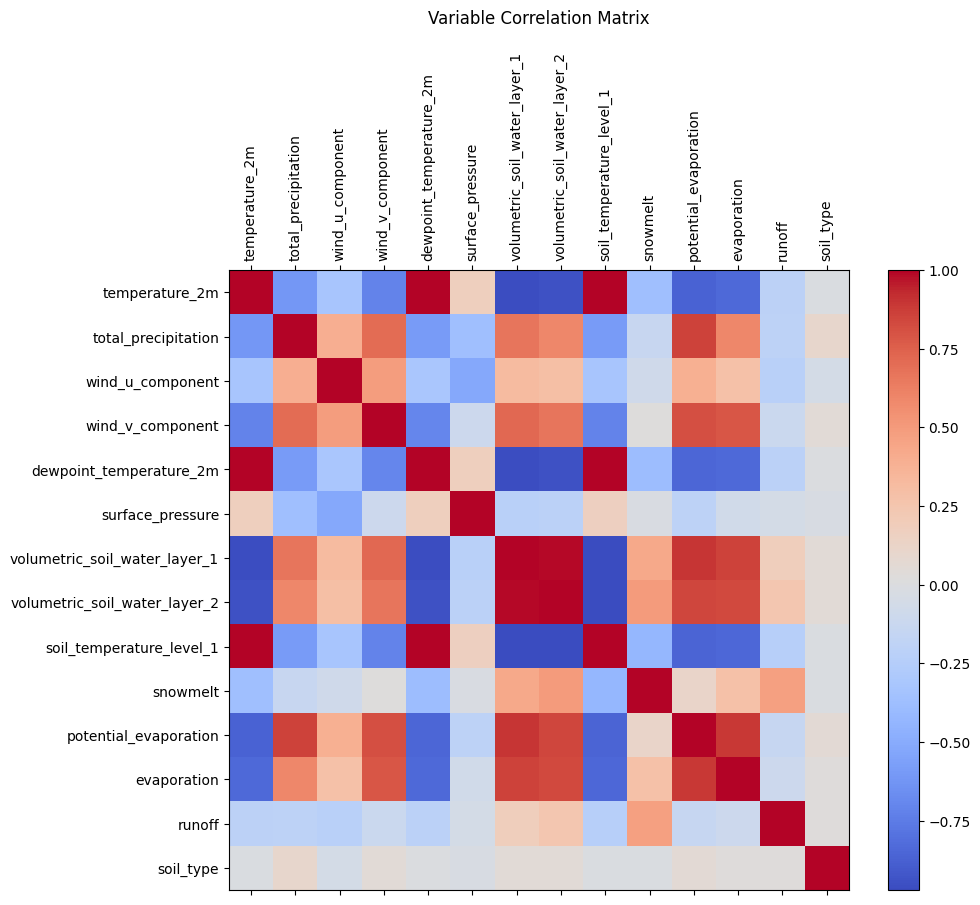


Correlation Matrix:
                               temperature_2m  total_precipitation  \
temperature_2m                       1.000000            -0.612703   
total_precipitation                 -0.612703             1.000000   
wind_u_component                    -0.320791             0.396381   
wind_v_component                    -0.716291             0.707067   
dewpoint_temperature_2m              0.998930            -0.592870   
surface_pressure                     0.173402            -0.366281   
volumetric_soil_water_layer_1       -0.959086             0.663211   
volumetric_soil_water_layer_2       -0.945664             0.590820   
soil_temperature_level_1             0.994207            -0.592447   
snowmelt                            -0.366926            -0.132891   
potential_evaporation               -0.864371             0.855498   
evaporation                         -0.838393             0.585317   
runoff                              -0.201814            -0.196583   

In [32]:
# Define Variables of Interest
print("\nStep 1: Exploring variables of interest...")
variables_of_interest = [
    "temperature_2m",
    "total_precipitation",
    "wind_u_component",
    "wind_v_component",
    "dewpoint_temperature_2m",
    "surface_pressure",
    "volumetric_soil_water_layer_1",
    "volumetric_soil_water_layer_2",
    "soil_temperature_level_1",
    "snowmelt",
    "potential_evaporation",
    "evaporation",
    "runoff",
    "soil_type"
]

# Prepare a list to store DataFrames for correlation analysis
data_frames = []

for i, ds in enumerate(processed_datasets):
    print(f"Processing Dataset {i} for correlation analysis...")
    
    # Filter variables of interest that exist in the current dataset
    available_vars = [var for var in variables_of_interest if var in ds]
    print(f"Variables available in Dataset {i}: {available_vars}")
    
    # Skip this dataset if none of the variables of interest are present
    if not available_vars:
        print(f"Dataset {i} contains no variables of interest. Skipping.")
        continue
    
    # Convert variables from Dataset to DataFrame 
    selected_vars = {var: ds[var].to_dataframe() for var in available_vars}
    
    # Combine into a single DataFrame
    combined_df = pd.concat(selected_vars.values(), axis=1)
    
    # Align by the time index
    combined_df = combined_df.groupby(level="time").mean()
    
    # Append to the list
    data_frames.append(combined_df)

# Combine DataFrames from All Datasets
if data_frames:
    print("\nMerging data from all datasets...")
    merged_data = pd.concat(data_frames, axis=1)

    # Drop rows with missing values
    merged_data = merged_data.dropna()
    print(f"Merged data shape: {merged_data.shape}")

    # Select only variables of interest for correlation analysis
    selected_columns = [col for col in variables_of_interest if col in merged_data.columns]
    filtered_data = merged_data[selected_columns]
    print(selected_columns)
    print(f"Filtered data shape: {filtered_data.shape}")

    # Compute Correlation Matrix
    print("\nComputing correlation matrix...")
    correlation_matrix = filtered_data.corr()

    # Visualize Correlation Matrix
    print("\nVisualizing correlation matrix...")
    plt.figure(figsize=(10, 8))
    plt.matshow(correlation_matrix, fignum=1, cmap="coolwarm")
    plt.colorbar()
    plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
    plt.yticks(range(len(correlation_matrix.index)), correlation_matrix.index)
    plt.title("Variable Correlation Matrix", pad=20)
    plt.show()

    # Print Correlation Matrix
    print("\nCorrelation Matrix:")
    print(correlation_matrix)
else:
    print("\nNo valid data for correlation analysis.")


#### Visualize Relationships Using Scatter Plots or Heatmaps & Check for Lagged Correlations


Step 5: Visualizing pairwise relationships...


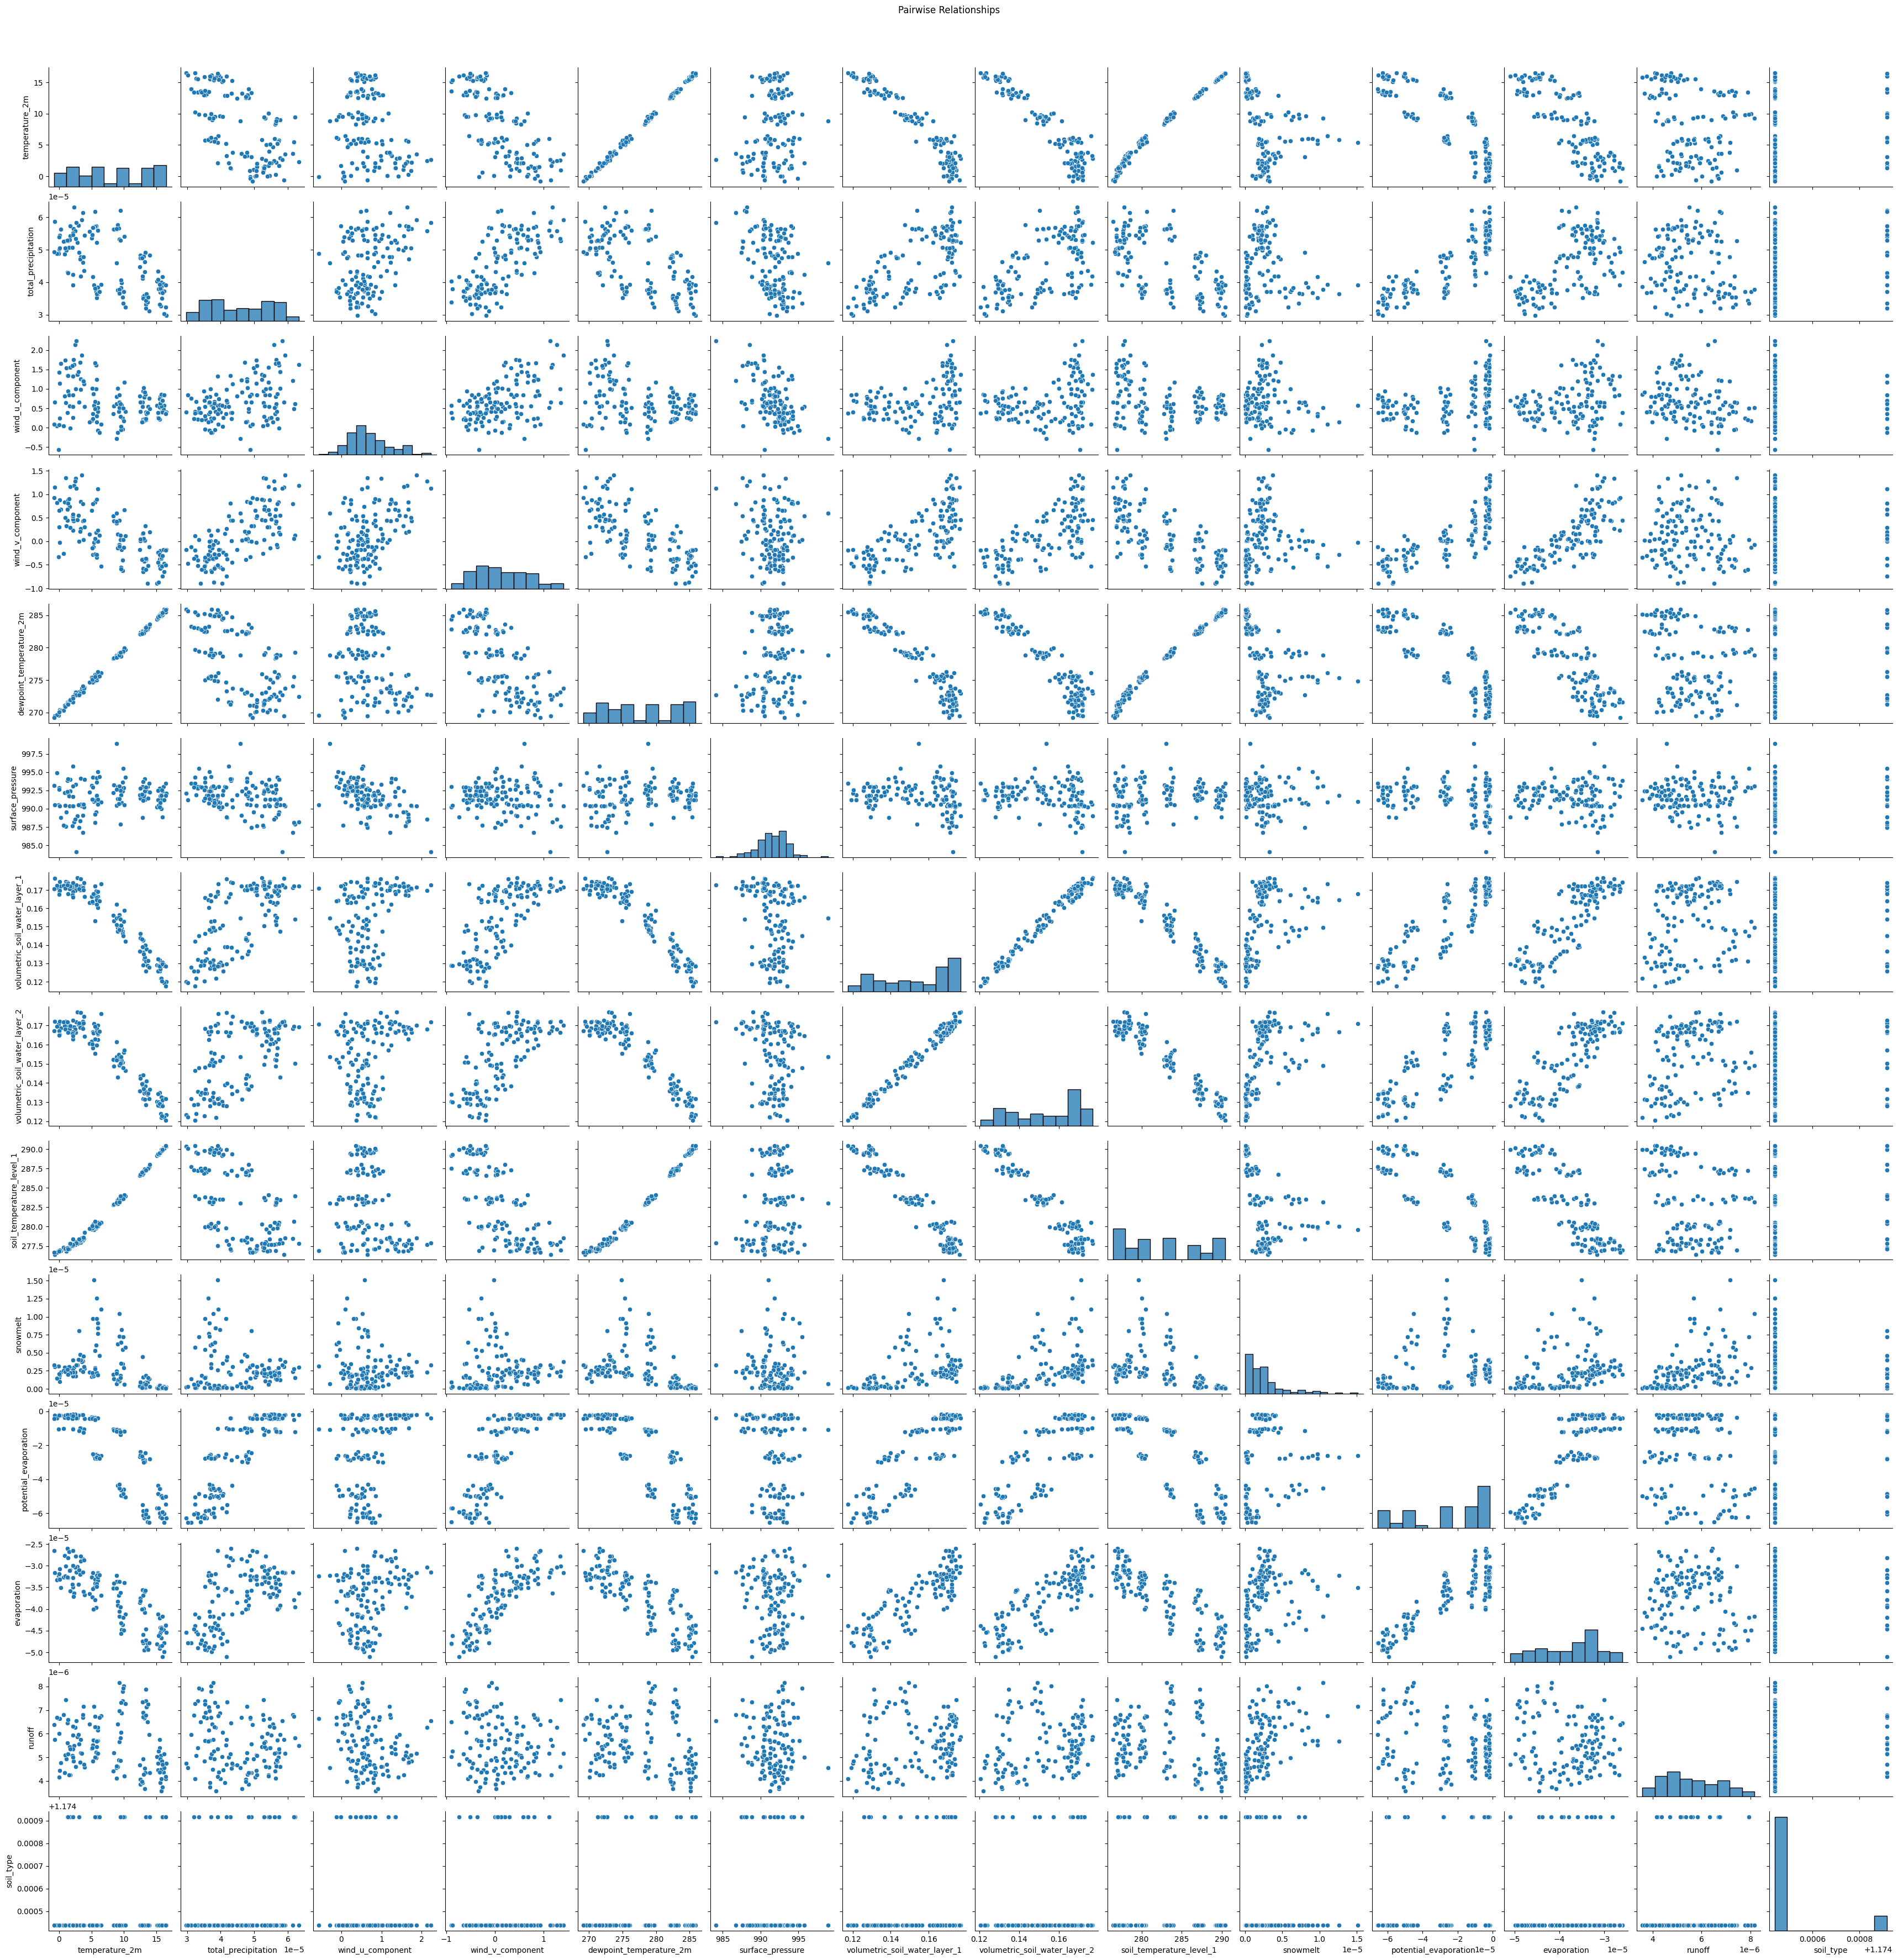


Step 6: Heatmap of the correlation matrix...


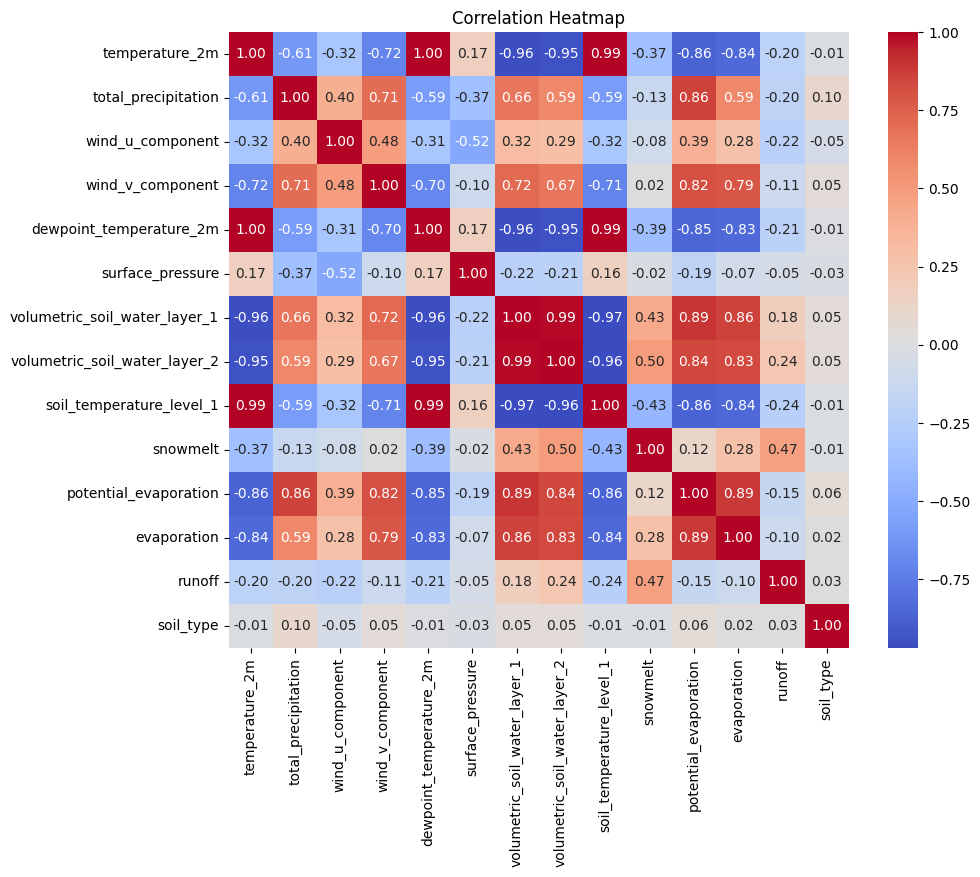


Step 7: Checking for lagged correlations...
Lag 1: Correlation between total_precipitation and volumetric_soil_water_layer_1 = 0.87
Lag 2: Correlation between total_precipitation and volumetric_soil_water_layer_1 = 0.83
Lag 3: Correlation between total_precipitation and volumetric_soil_water_layer_1 = 0.60
Lag 4: Correlation between total_precipitation and volumetric_soil_water_layer_1 = 0.21
Lag 5: Correlation between total_precipitation and volumetric_soil_water_layer_1 = -0.23
Lag 6: Correlation between total_precipitation and volumetric_soil_water_layer_1 = -0.62


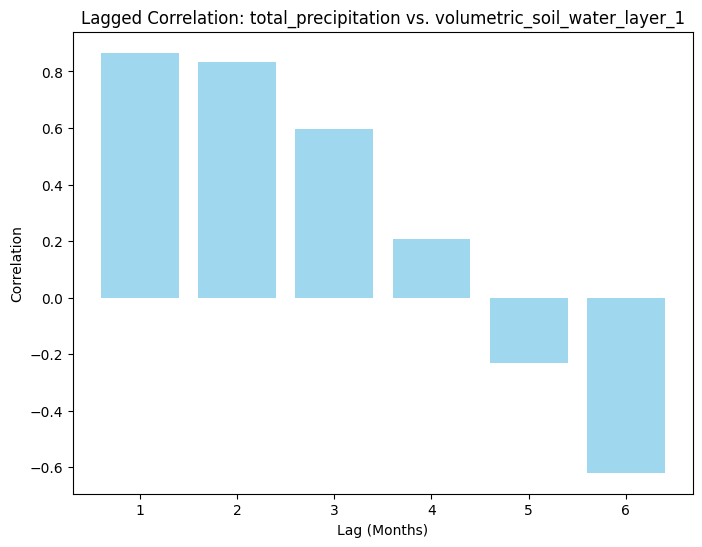

In [33]:
# Step 5: Visualize Relationships Using Scatter Plots and Heatmaps
print("\nStep 5: Visualizing pairwise relationships...")

# Scatter plot for pairwise relationships
sns.pairplot(merged_data[selected_columns])
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()

# Heatmap for the correlation matrix
print("\nStep 6: Heatmap of the correlation matrix...")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

# Step 7: Lagged Correlation Analysis
print("\nStep 7: Checking for lagged correlations...")

# Define variables to analyze lagged correlation (e.g., precipitation vs. soil water levels)
lag_variable = "total_precipitation"
response_variable = "volumetric_soil_water_layer_1"

# Maximum number of lags to check
max_lag = 6

# Calculate lagged correlations
lagged_correlations = []
for lag in range(1, max_lag + 1):
    shifted_data = merged_data[lag_variable].shift(lag)  # Shift precipitation data by 'lag' months
    correlation = merged_data[response_variable].corr(shifted_data)
    lagged_correlations.append((lag, correlation))
    print(f"Lag {lag}: Correlation between {lag_variable} and {response_variable} = {correlation:.2f}")

# Visualize lagged correlations
lags, correlations = zip(*lagged_correlations)
plt.figure(figsize=(8, 6))
plt.bar(lags, correlations, color="skyblue", alpha=0.8)
plt.xlabel("Lag (Months)")
plt.ylabel("Correlation")
plt.title(f"Lagged Correlation: {lag_variable} vs. {response_variable}")
plt.xticks(lags)
plt.show()


#### Calculate lagged correlations between temperature_2m and volumetric_soil_water_layer_1


Step 7: Checking for lagged correlations...
Lag 1: Correlation between temperature_2m and volumetric_soil_water_layer_1 = -0.79
Lag 2: Correlation between temperature_2m and volumetric_soil_water_layer_1 = -0.40
Lag 3: Correlation between temperature_2m and volumetric_soil_water_layer_1 = 0.09
Lag 4: Correlation between temperature_2m and volumetric_soil_water_layer_1 = 0.54
Lag 5: Correlation between temperature_2m and volumetric_soil_water_layer_1 = 0.84
Lag 6: Correlation between temperature_2m and volumetric_soil_water_layer_1 = 0.93


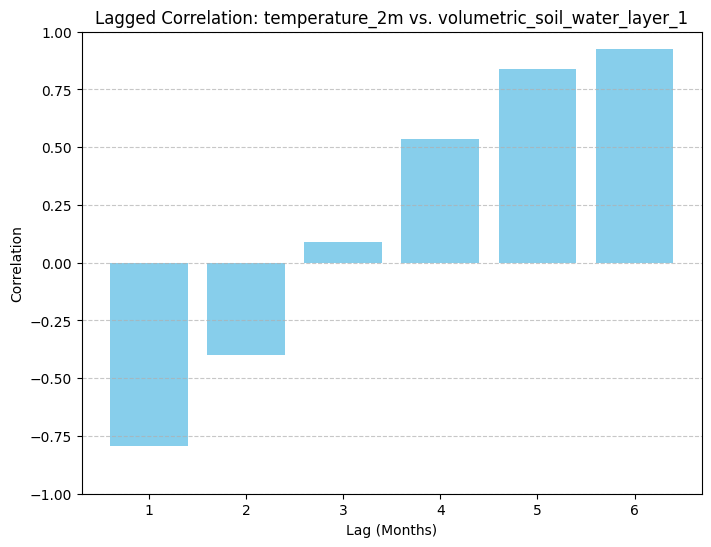

In [34]:
# Define variables for lagged correlation
lag_variable = "temperature_2m"  # Predictor variable
response_variable = "volumetric_soil_water_layer_1"  # Response variable
max_lag = 6  # Maximum lag to test (in months)

# Initialize a list to store lagged correlations
lagged_correlations = []

print("\nStep 7: Checking for lagged correlations...")
for lag in range(1, max_lag + 1):
    # Shift the temperature data by 'lag' months
    shifted_data = merged_data[lag_variable].shift(lag)
    
    # Compute the correlation with soil water content
    correlation = merged_data[response_variable].corr(shifted_data)
    
    # Store the lag and correlation
    lagged_correlations.append((lag, correlation))
    print(f"Lag {lag}: Correlation between {lag_variable} and {response_variable} = {correlation:.2f}")

# Convert lagged correlations into a DataFrame for visualization
lagged_df = pd.DataFrame(lagged_correlations, columns=["Lag (Months)", "Correlation"])

# Plot lagged correlations
plt.figure(figsize=(8, 6))
plt.bar(lagged_df["Lag (Months)"], lagged_df["Correlation"], color="skyblue")
plt.xlabel("Lag (Months)")
plt.ylabel("Correlation")
plt.title(f"Lagged Correlation: {lag_variable} vs. {response_variable}")
plt.xticks(range(1, max_lag + 1))
plt.ylim(-1, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


#### Calculate lagged correlations between total_precipitation and runoff (Analyze rainfall impact on runoff)


Step: Checking for lagged correlations...
Lag 1: Correlation between total_precipitation and runoff = 0.09
Lag 2: Correlation between total_precipitation and runoff = 0.34
Lag 3: Correlation between total_precipitation and runoff = 0.53
Lag 4: Correlation between total_precipitation and runoff = 0.57
Lag 5: Correlation between total_precipitation and runoff = 0.49
Lag 6: Correlation between total_precipitation and runoff = 0.30


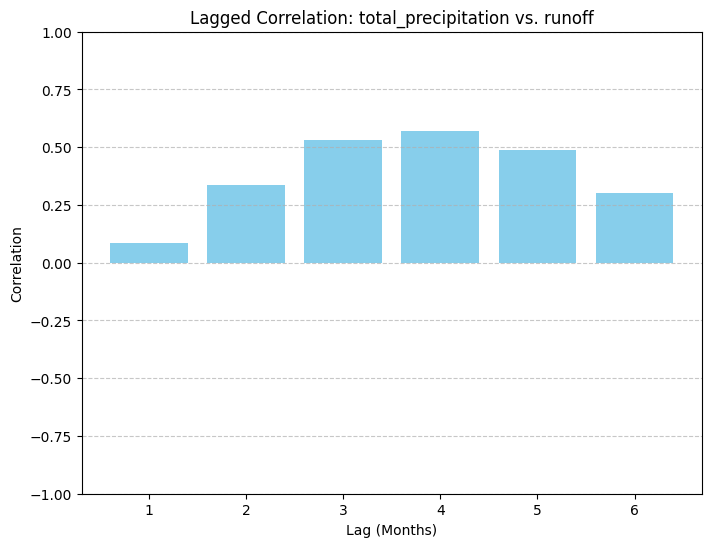

In [35]:
# Variables to analyze lagged correlation
lag_variable = "total_precipitation"  # Predictor variable (rainfall)
response_variable = "runoff"  # Response variable (runoff)
max_lag = 6  # Maximum lag to test (in months)

# Initialize a list to store lagged correlations
lagged_correlations = []

print("\nStep: Checking for lagged correlations...")
for lag in range(1, max_lag + 1):
    # Shift the predictor variable by 'lag' months
    shifted_data = filtered_data[lag_variable].shift(lag)
    
    # Compute correlation with the response variable
    correlation = filtered_data[response_variable].corr(shifted_data)
    
    # Store the lag and correlation
    lagged_correlations.append((lag, correlation))
    print(f"Lag {lag}: Correlation between {lag_variable} and {response_variable} = {correlation:.2f}")

# Convert lagged correlations into a DataFrame for visualization
lagged_df = pd.DataFrame(lagged_correlations, columns=["Lag (Months)", "Correlation"])

# Plot lagged correlations
plt.figure(figsize=(8, 6))
plt.bar(lagged_df["Lag (Months)"], lagged_df["Correlation"], color="skyblue")
plt.xlabel("Lag (Months)")
plt.ylabel("Correlation")
plt.title(f"Lagged Correlation: {lag_variable} vs. {response_variable}")
plt.xticks(range(1, max_lag + 1))
plt.ylim(-1, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


#### Calculate lagged correlations between snowmelt and volumetric_soil_water_layer_2 
#### (Analyze snowmelt's delayed effects on deeper soil water)


Step: Checking for lagged correlations...
Lag 1: Correlation between snowmelt and volumetric_soil_water_layer_2 = 0.06
Lag 2: Correlation between snowmelt and volumetric_soil_water_layer_2 = -0.36
Lag 3: Correlation between snowmelt and volumetric_soil_water_layer_2 = -0.63
Lag 4: Correlation between snowmelt and volumetric_soil_water_layer_2 = -0.65
Lag 5: Correlation between snowmelt and volumetric_soil_water_layer_2 = -0.46
Lag 6: Correlation between snowmelt and volumetric_soil_water_layer_2 = -0.19


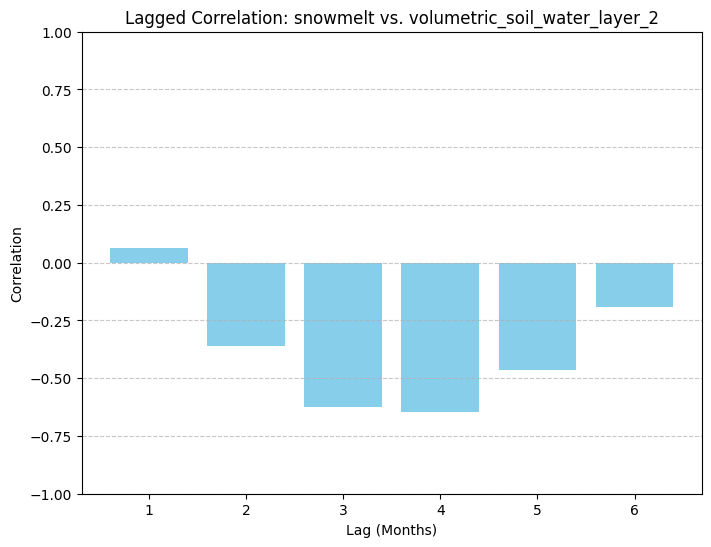

In [36]:
# Variables to analyze lagged correlation
lag_variable = "snowmelt"  # Predictor variable (snowmelt)
response_variable = "volumetric_soil_water_layer_2"  # Response variable (deep soil water)
max_lag = 6  # Maximum lag to test (in months)

# Initialize a list to store lagged correlations
lagged_correlations = []

print("\nStep: Checking for lagged correlations...")
for lag in range(1, max_lag + 1):
    # Shift the predictor variable by 'lag' months
    shifted_data = filtered_data[lag_variable].shift(lag)
    
    # Compute correlation with the response variable
    correlation = filtered_data[response_variable].corr(shifted_data)
    
    # Store the lag and correlation
    lagged_correlations.append((lag, correlation))
    print(f"Lag {lag}: Correlation between {lag_variable} and {response_variable} = {correlation:.2f}")

# Convert lagged correlations into a DataFrame for visualization
lagged_df = pd.DataFrame(lagged_correlations, columns=["Lag (Months)", "Correlation"])

# Plot lagged correlations
plt.figure(figsize=(8, 6))
plt.bar(lagged_df["Lag (Months)"], lagged_df["Correlation"], color="skyblue")
plt.xlabel("Lag (Months)")
plt.ylabel("Correlation")
plt.title(f"Lagged Correlation: {lag_variable} vs. {response_variable}")
plt.xticks(range(1, max_lag + 1))
plt.ylim(-1, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


#### Calculate lagged correlations between temperature_2m and potential_evaporation 
#### (Study how temperature impacts evaporation over time)


Step: Checking for lagged correlations...
Lag 1: Correlation between temperature_2m and potential_evaporation = -0.51
Lag 2: Correlation between temperature_2m and potential_evaporation = -0.02
Lag 3: Correlation between temperature_2m and potential_evaporation = 0.46
Lag 4: Correlation between temperature_2m and potential_evaporation = 0.80
Lag 5: Correlation between temperature_2m and potential_evaporation = 0.94
Lag 6: Correlation between temperature_2m and potential_evaporation = 0.84


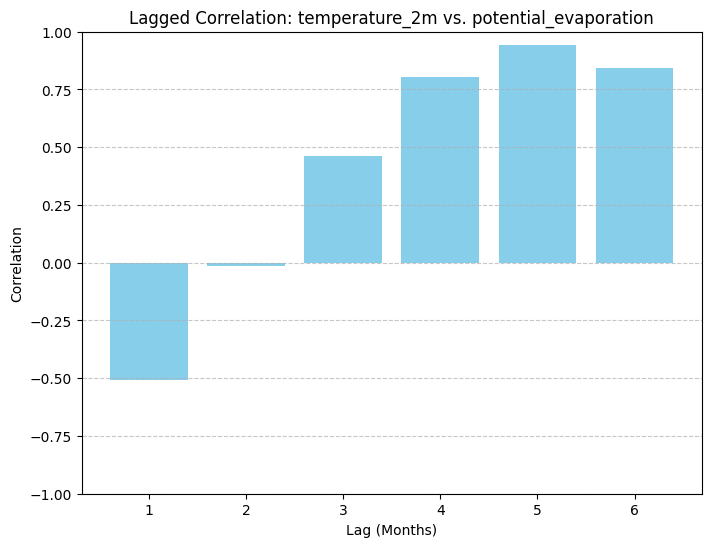

In [37]:
# Variables to analyze lagged correlation
lag_variable = "temperature_2m"  # Predictor variable (temperature)
response_variable = "potential_evaporation"  # Response variable (evaporation potential)
max_lag = 6  # Maximum lag to test (in months)

# Initialize a list to store lagged correlations
lagged_correlations = []

print("\nStep: Checking for lagged correlations...")
for lag in range(1, max_lag + 1):
    # Shift the predictor variable by 'lag' months
    shifted_data = filtered_data[lag_variable].shift(lag)
    
    # Compute correlation with the response variable
    correlation = filtered_data[response_variable].corr(shifted_data)
    
    # Store the lag and correlation
    lagged_correlations.append((lag, correlation))
    print(f"Lag {lag}: Correlation between {lag_variable} and {response_variable} = {correlation:.2f}")

# Convert lagged correlations into a DataFrame for visualization
lagged_df = pd.DataFrame(lagged_correlations, columns=["Lag (Months)", "Correlation"])

# Plot lagged correlations
plt.figure(figsize=(8, 6))
plt.bar(lagged_df["Lag (Months)"], lagged_df["Correlation"], color="skyblue")
plt.xlabel("Lag (Months)")
plt.ylabel("Correlation")
plt.title(f"Lagged Correlation: {lag_variable} vs. {response_variable}")
plt.xticks(range(1, max_lag + 1))
plt.ylim(-1, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


#### Trend Analysis


Analyzing trend for: temperature_2m...


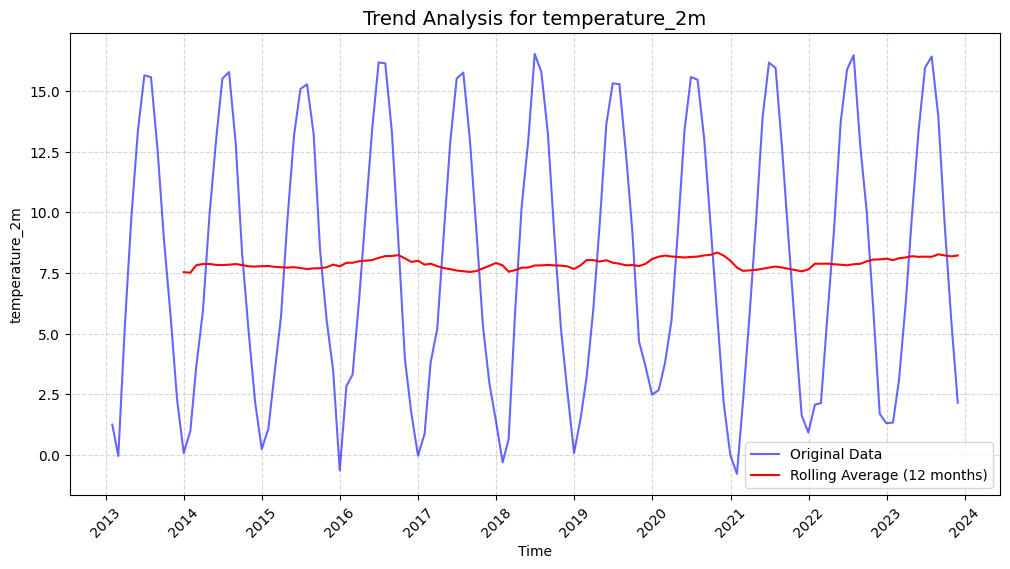


Analyzing trend for: total_precipitation...


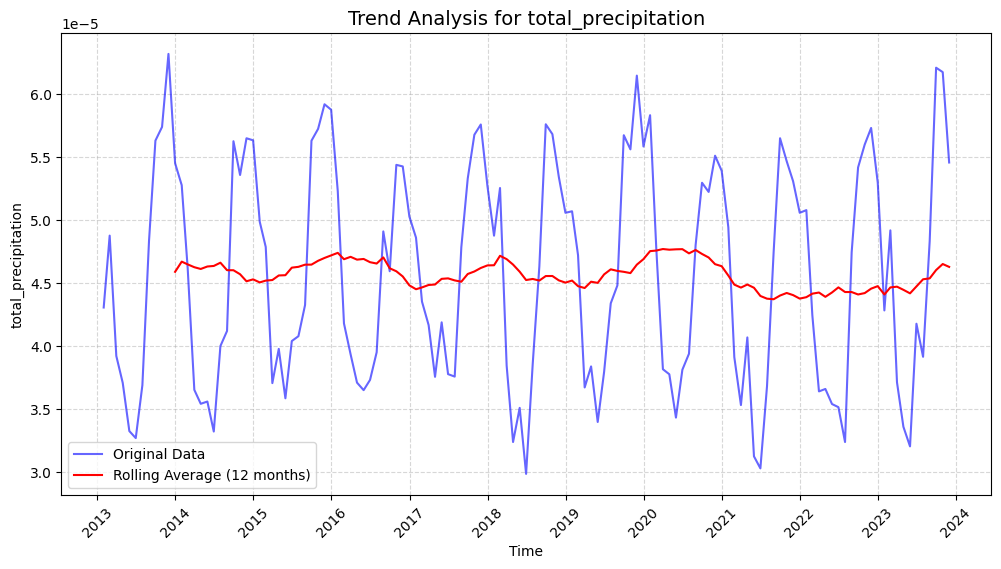


Analyzing trend for: wind_u_component...


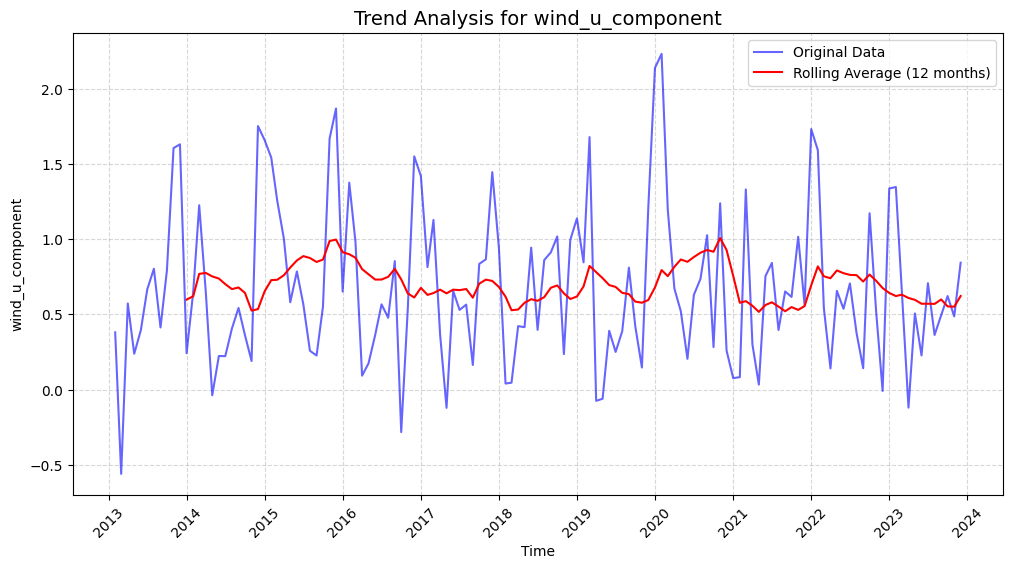


Analyzing trend for: wind_v_component...


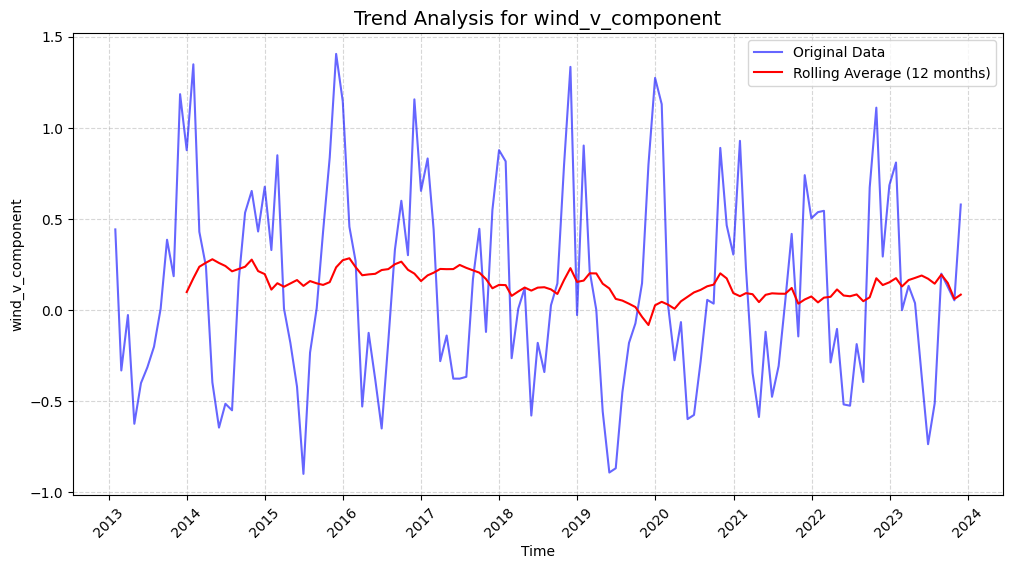


Analyzing trend for: dewpoint_temperature_2m...


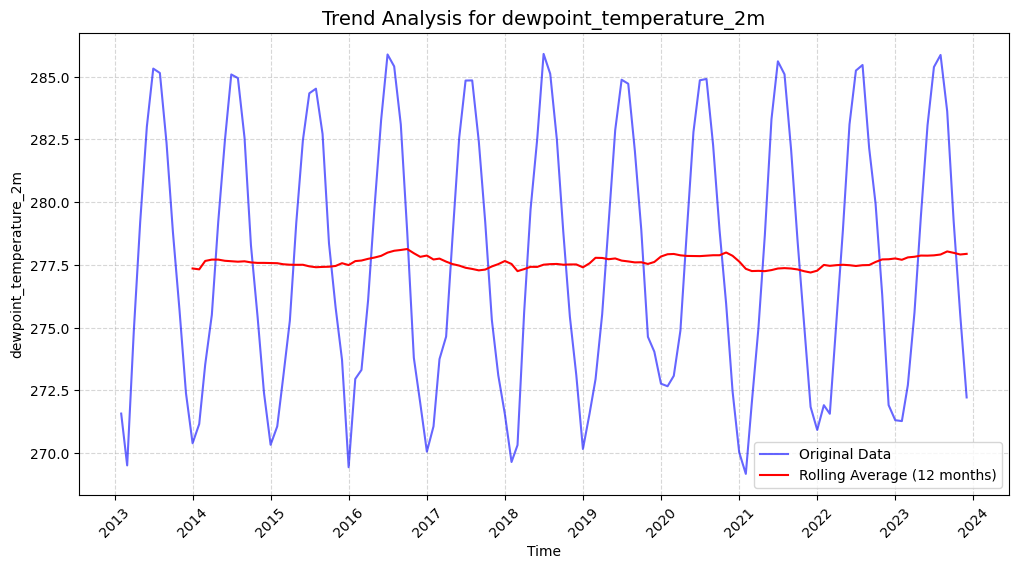


Analyzing trend for: surface_pressure...


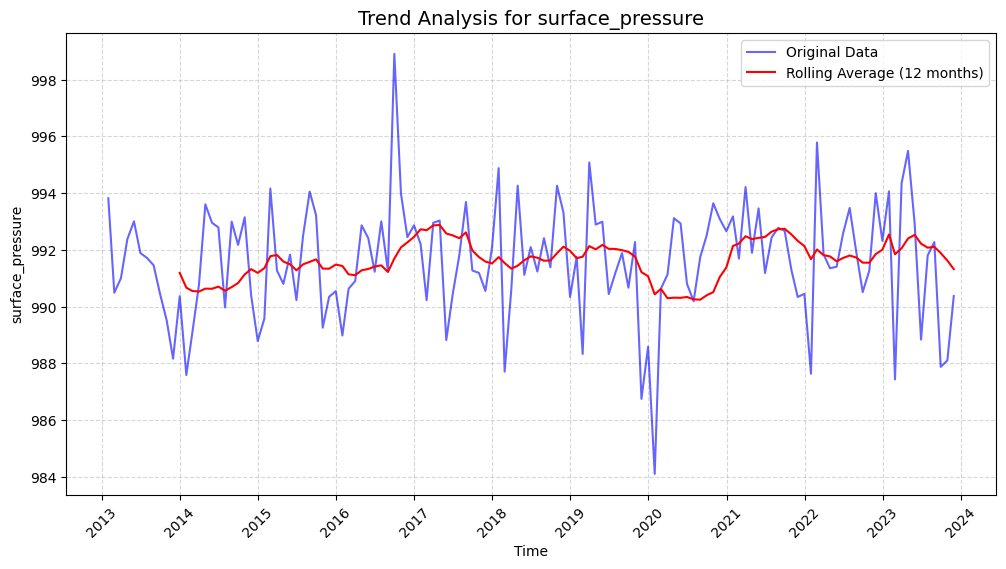


Analyzing trend for: volumetric_soil_water_layer_1...


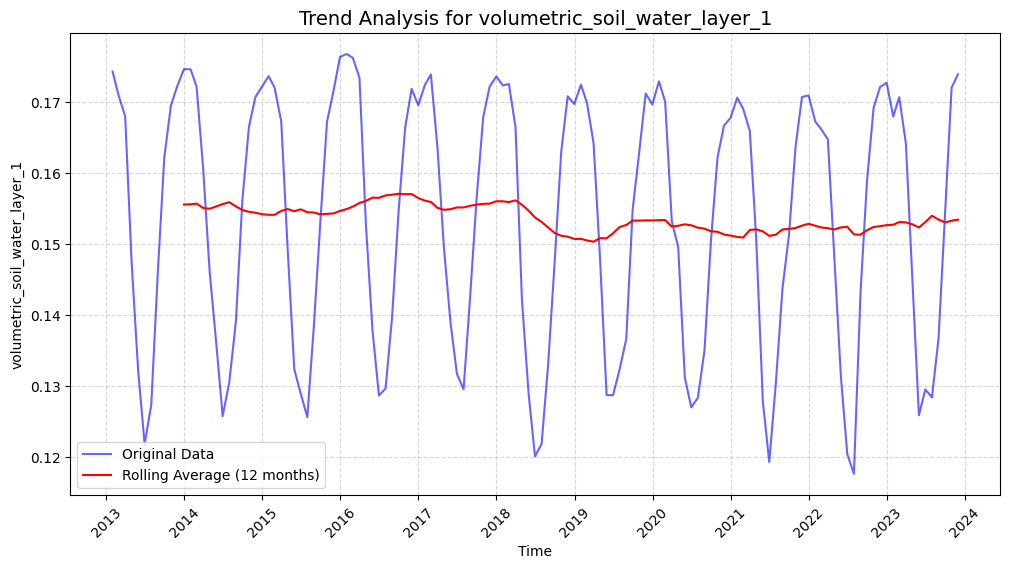


Analyzing trend for: volumetric_soil_water_layer_2...


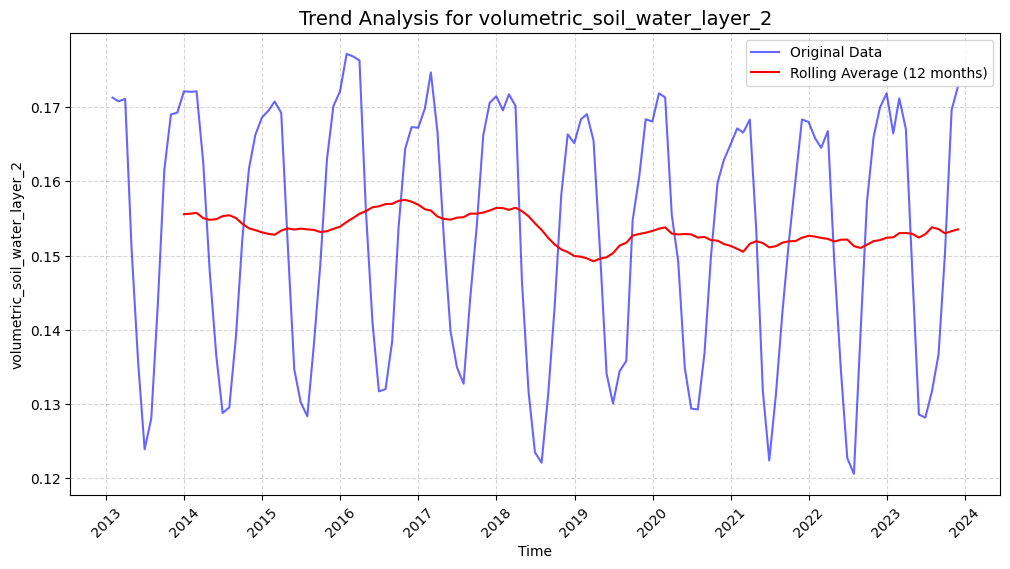


Analyzing trend for: soil_temperature_level_1...


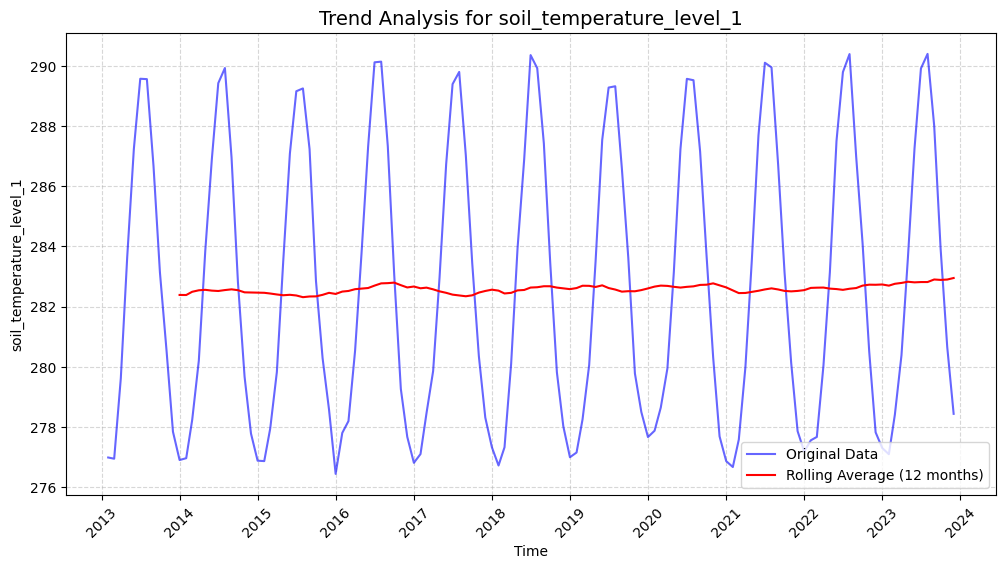


Analyzing trend for: snowmelt...


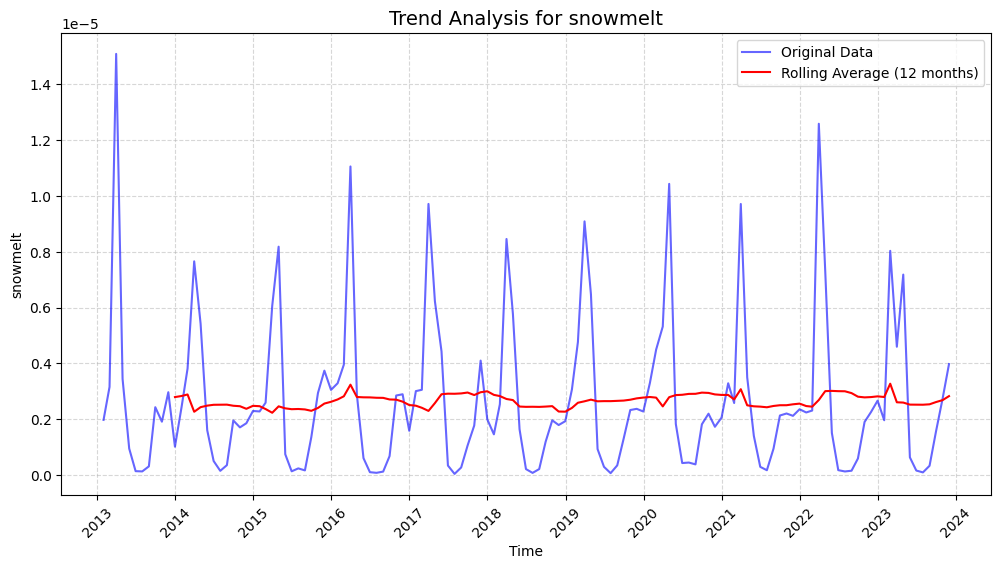


Analyzing trend for: potential_evaporation...


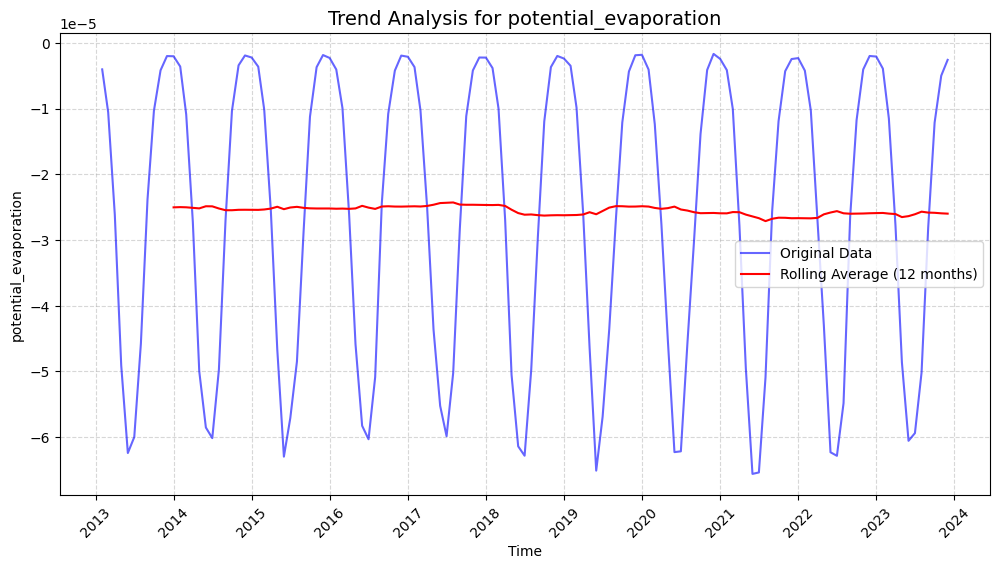


Analyzing trend for: evaporation...


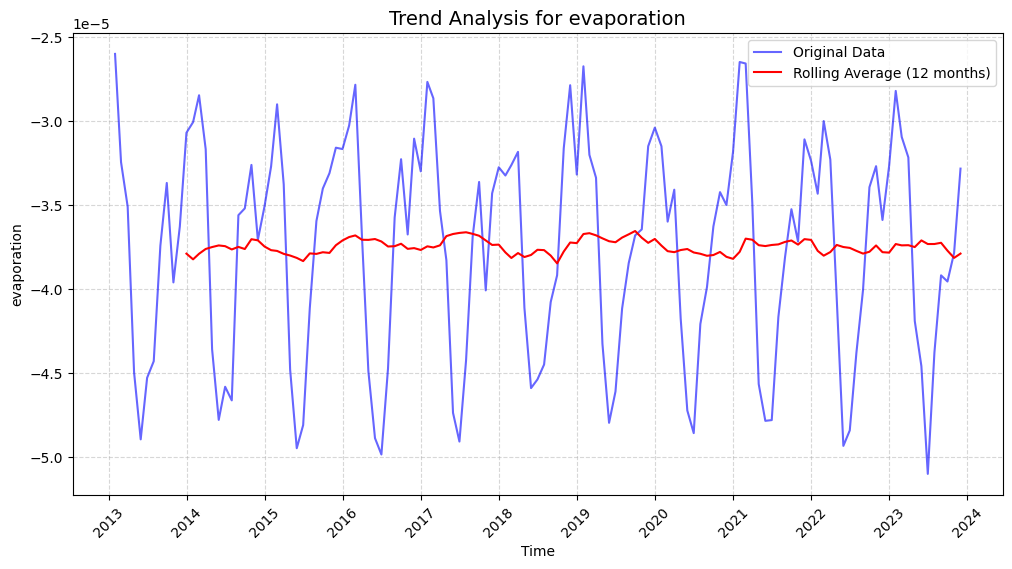


Analyzing trend for: runoff...


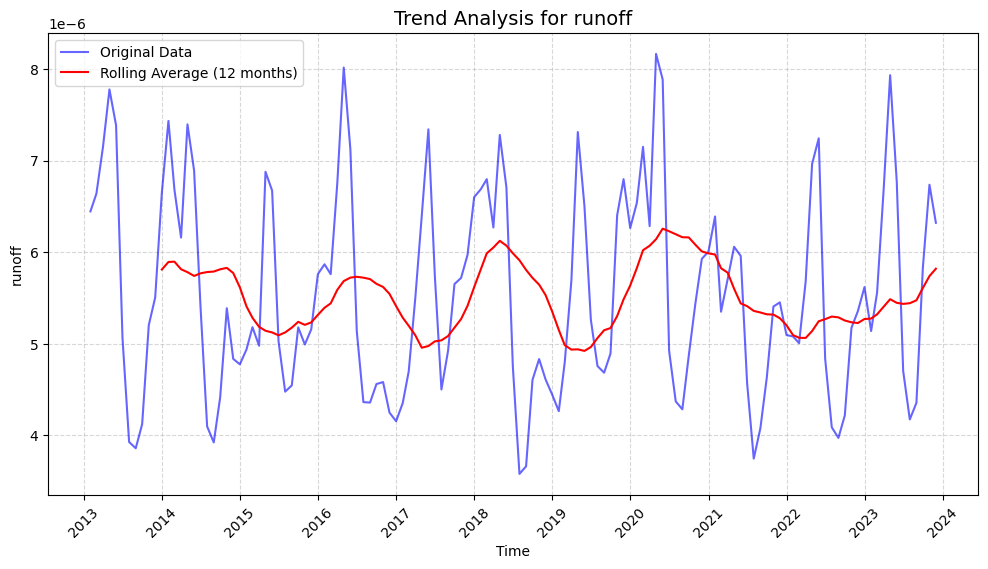


Analyzing trend for: soil_type...


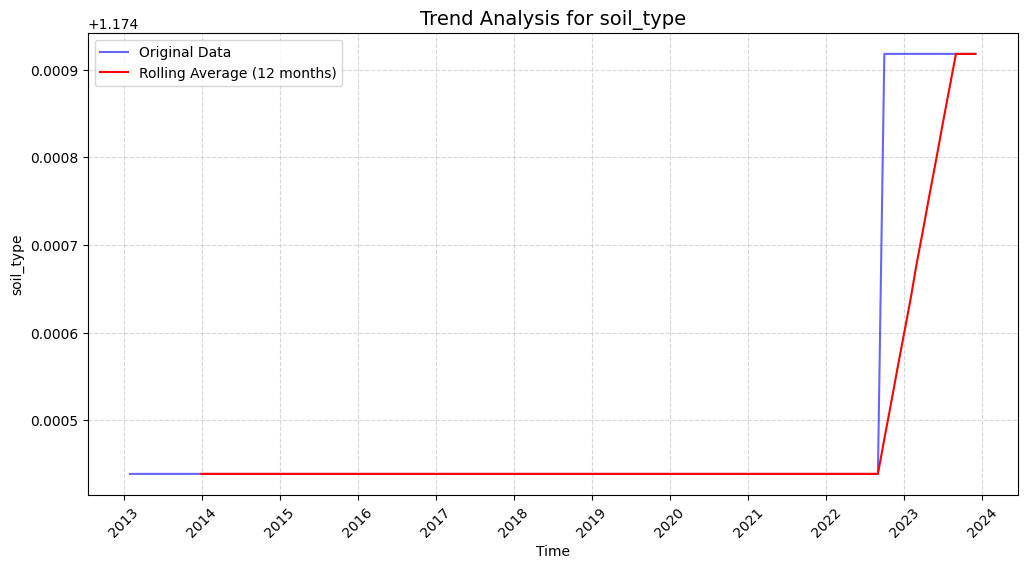

In [38]:
# Loop through each variable to analyze trends
for var in variables_of_interest:
    if var in merged_data.columns:
        print(f"\nAnalyzing trend for: {var}...")
        
        # Get the time series for the variable
        time_series = merged_data[var]
        
        # Fill missing values
        time_series = time_series.interpolate(method="linear")
        
        # Calculate a rolling average (12-month moving average)
        rolling_avg = time_series.rolling(window=12).mean()
        
        # Plot the original data and rolling average
        plt.figure(figsize=(12, 6))
        plt.plot(time_series, label="Original Data", color="blue", alpha=0.6)
        plt.plot(rolling_avg, label="Rolling Average (12 months)", color="red")
        
        # Add title and labels
        plt.title(f"Trend Analysis for {var}", fontsize=14)
        plt.xlabel("Time")
        plt.ylabel(var)
        
        # Format x-axis to show years
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xticks(rotation=45)  # Rotate year labels
        
        # Add grid and legend
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.legend()
        
        # Show the plot
        plt.show()
    else:
        print(f"Variable '{var}' not found in the dataset.")



#### Spatial Analysis

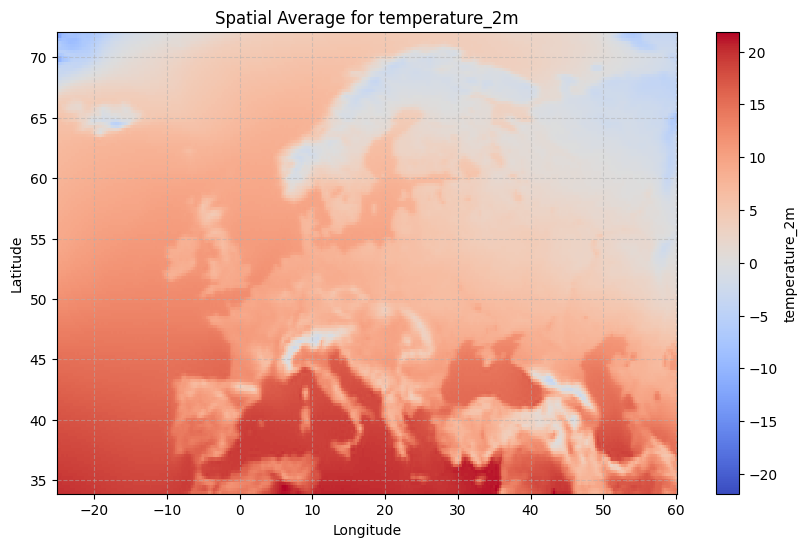

Extreme regions for temperature_2m:
 <xarray.DataArray 'temperature_2m' (latitude: 153, longitude: 341)> Size: 52kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])
Coordinates:
  * latitude   (latitude) float64 1kB 34.0 34.25 34.5 34.75 ... 71.5 71.75 72.0
  * longitude  (longitude) float64 3kB -25.0 -24.75 -24.5 ... 59.5 59.75 60.0
    number     int32 4B 0
    step       timedelta64[ns] 8B 00:00:00
    surface    float64 8B 0.0


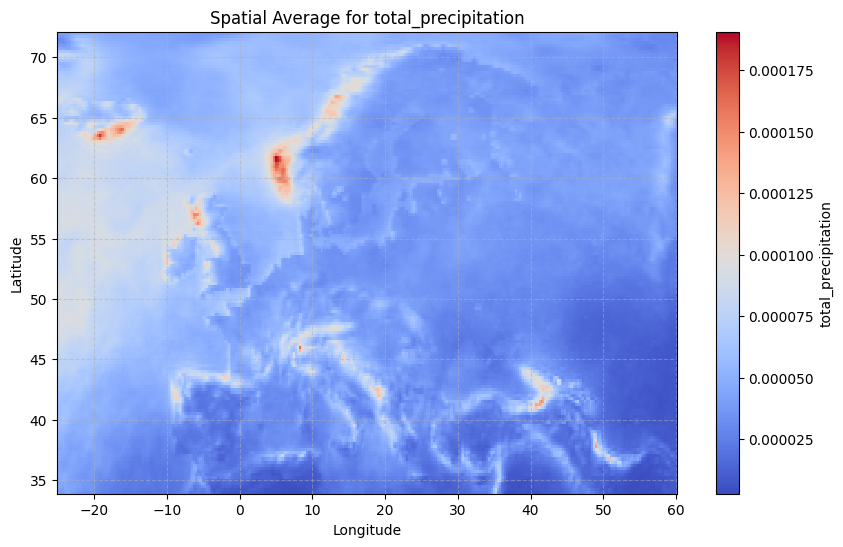

Extreme regions for total_precipitation:
 <xarray.DataArray 'total_precipitation' (latitude: 153, longitude: 341)> Size: 52kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * latitude   (latitude) float64 1kB 34.0 34.25 34.5 34.75 ... 71.5 71.75 72.0
  * longitude  (longitude) float64 3kB -25.0 -24.75 -24.5 ... 59.5 59.75 60.0
    number     int32 4B 0
    surface    float64 8B 0.0


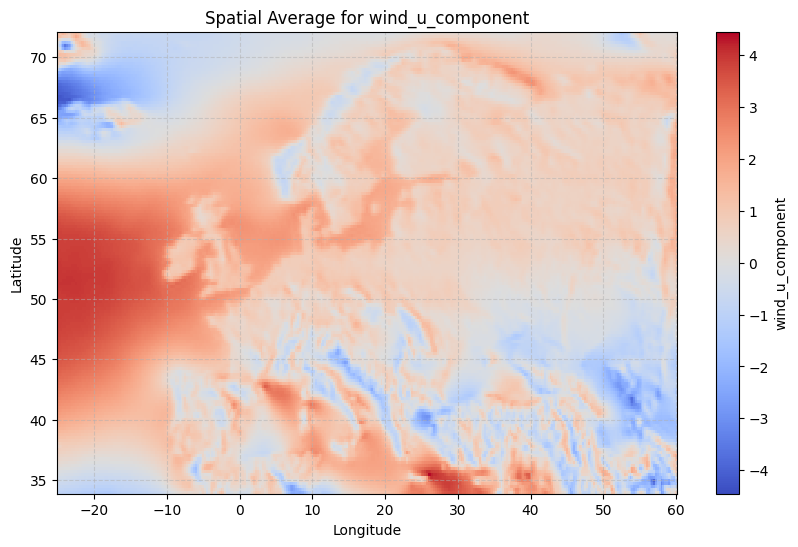

Extreme regions for wind_u_component:
 <xarray.DataArray 'wind_u_component' (latitude: 153, longitude: 341)> Size: 52kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * latitude   (latitude) float64 1kB 34.0 34.25 34.5 34.75 ... 71.5 71.75 72.0
  * longitude  (longitude) float64 3kB -25.0 -24.75 -24.5 ... 59.5 59.75 60.0
    number     int32 4B 0
    step       timedelta64[ns] 8B 00:00:00
    surface    float64 8B 0.0


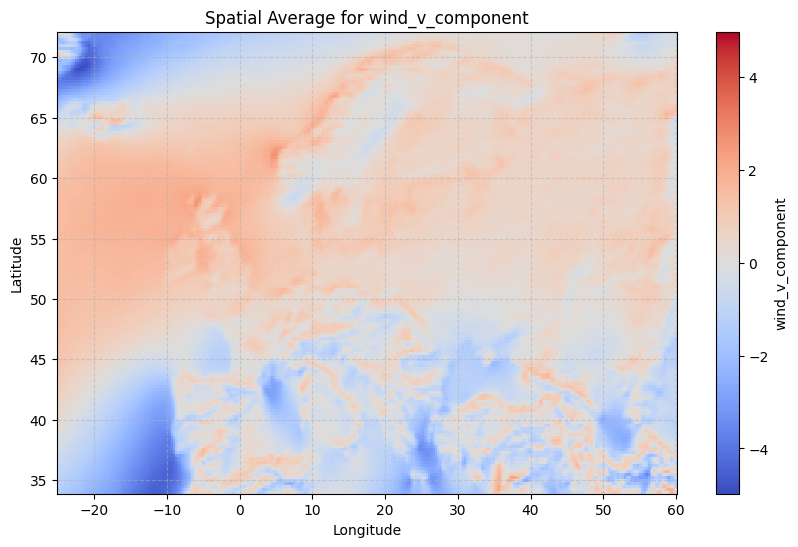

Extreme regions for wind_v_component:
 <xarray.DataArray 'wind_v_component' (latitude: 153, longitude: 341)> Size: 52kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * latitude   (latitude) float64 1kB 34.0 34.25 34.5 34.75 ... 71.5 71.75 72.0
  * longitude  (longitude) float64 3kB -25.0 -24.75 -24.5 ... 59.5 59.75 60.0
    number     int32 4B 0
    step       timedelta64[ns] 8B 00:00:00
    surface    float64 8B 0.0


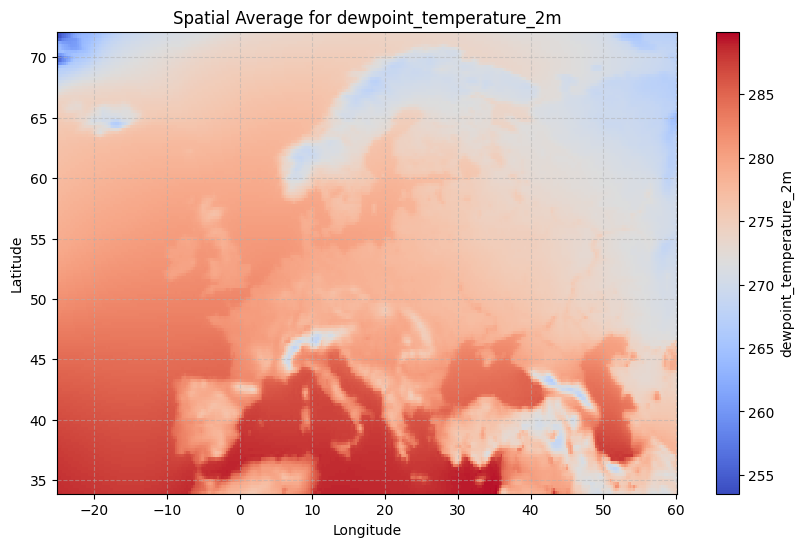

Extreme regions for dewpoint_temperature_2m:
 <xarray.DataArray 'dewpoint_temperature_2m' (latitude: 153, longitude: 341)> Size: 52kB
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])
Coordinates:
  * latitude   (latitude) float64 1kB 34.0 34.25 34.5 34.75 ... 71.5 71.75 72.0
  * longitude  (longitude) float64 3kB -25.0 -24.75 -24.5 ... 59.5 59.75 60.0
    number     int32 4B 0
    step       timedelta64[ns] 8B 00:00:00
    surface    float64 8B 0.0


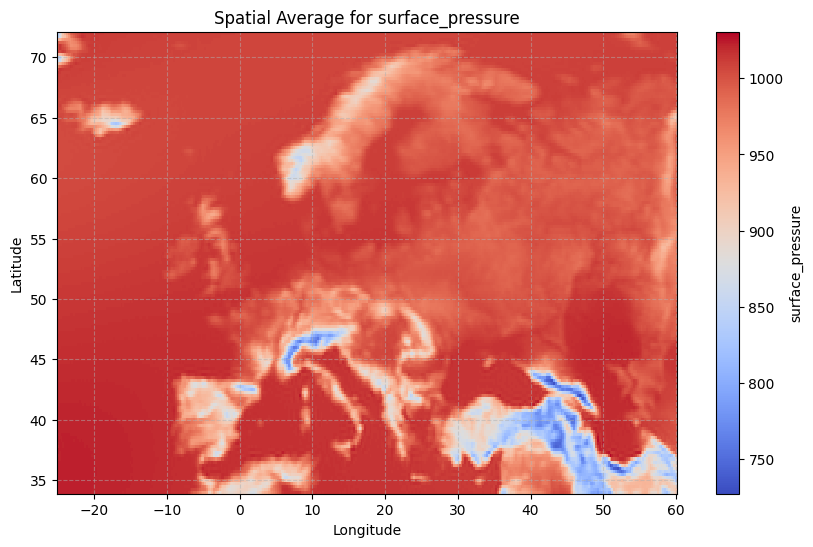

Extreme regions for surface_pressure:
 <xarray.DataArray 'surface_pressure' (latitude: 153, longitude: 341)> Size: 52kB
array([[False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])
Coordinates:
  * latitude   (latitude) float64 1kB 34.0 34.25 34.5 34.75 ... 71.5 71.75 72.0
  * longitude  (longitude) float64 3kB -25.0 -24.75 -24.5 ... 59.5 59.75 60.0
    number     int32 4B 0
    step       timedelta64[ns] 8B 00:00:00
    surface    float64 8B 0.0


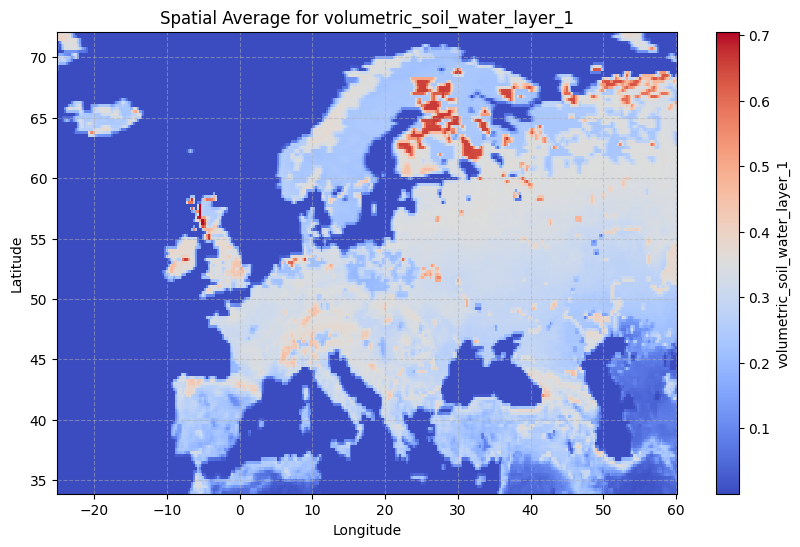

Extreme regions for volumetric_soil_water_layer_1:
 <xarray.DataArray 'volumetric_soil_water_layer_1' (latitude: 153, longitude: 341)> Size: 52kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * latitude             (latitude) float64 1kB 34.0 34.25 34.5 ... 71.75 72.0
  * longitude            (longitude) float64 3kB -25.0 -24.75 ... 59.75 60.0
    number               int32 4B 0
    step                 timedelta64[ns] 8B 00:00:00
    depthBelowLandLayer  float64 8B 0.0


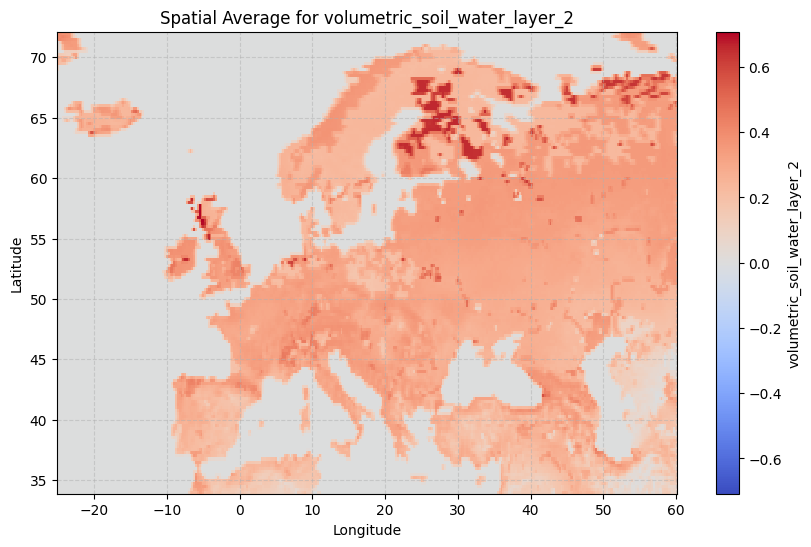

Extreme regions for volumetric_soil_water_layer_2:
 <xarray.DataArray 'volumetric_soil_water_layer_2' (latitude: 153, longitude: 341)> Size: 52kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * latitude             (latitude) float64 1kB 34.0 34.25 34.5 ... 71.75 72.0
  * longitude            (longitude) float64 3kB -25.0 -24.75 ... 59.75 60.0
    number               int32 4B 0
    step                 timedelta64[ns] 8B 00:00:00
    depthBelowLandLayer  float64 8B 7.0


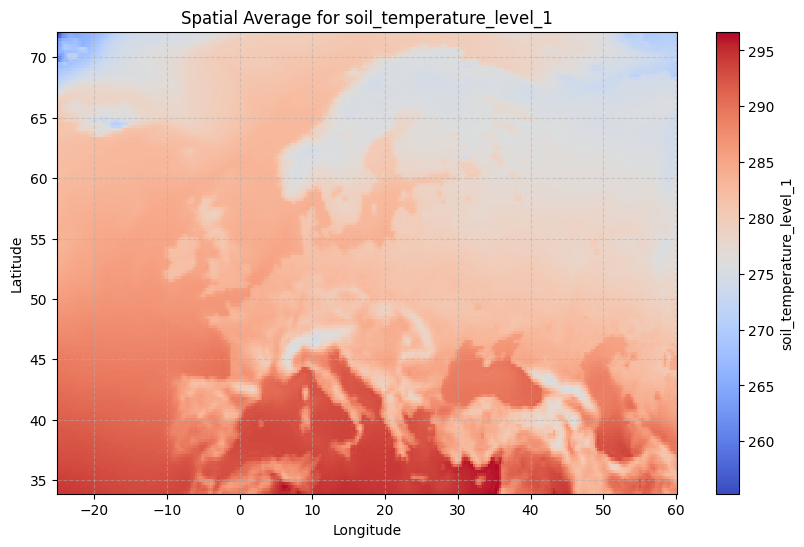

Extreme regions for soil_temperature_level_1:
 <xarray.DataArray 'soil_temperature_level_1' (latitude: 153, longitude: 341)> Size: 52kB
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * latitude             (latitude) float64 1kB 34.0 34.25 34.5 ... 71.75 72.0
  * longitude            (longitude) float64 3kB -25.0 -24.75 ... 59.75 60.0
    number               int32 4B 0
    step                 timedelta64[ns] 8B 00:00:00
    depthBelowLandLayer  float64 8B 0.0


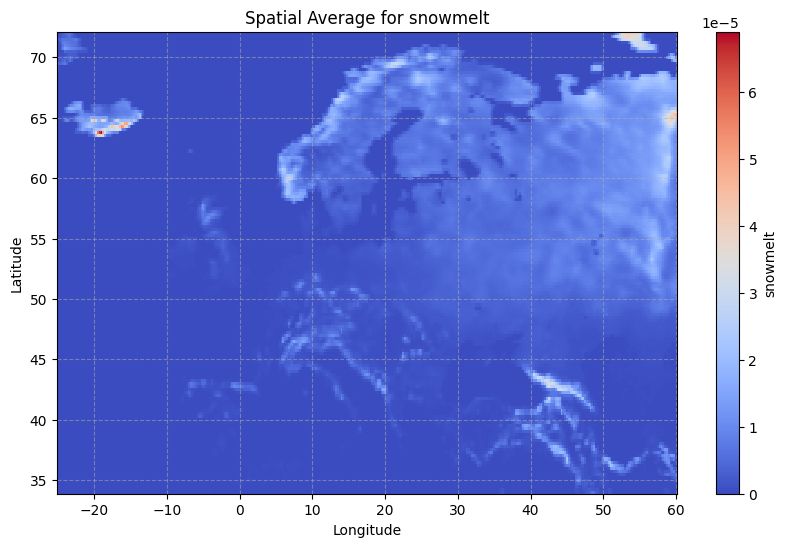

Extreme regions for snowmelt:
 <xarray.DataArray 'snowmelt' (latitude: 153, longitude: 341)> Size: 52kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * latitude   (latitude) float64 1kB 34.0 34.25 34.5 34.75 ... 71.5 71.75 72.0
  * longitude  (longitude) float64 3kB -25.0 -24.75 -24.5 ... 59.5 59.75 60.0
    number     int32 4B 0
    surface    float64 8B 0.0


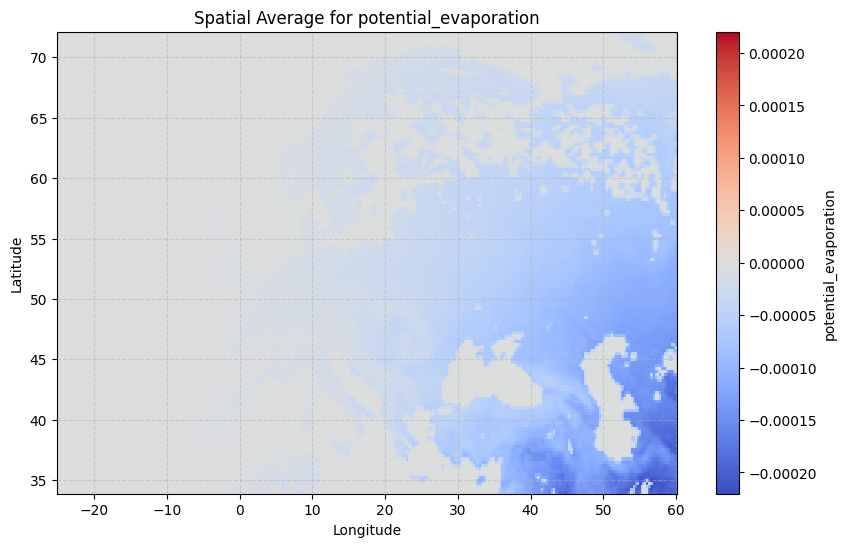

Extreme regions for potential_evaporation:
 <xarray.DataArray 'potential_evaporation' (latitude: 153, longitude: 341)> Size: 52kB
array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * latitude   (latitude) float64 1kB 34.0 34.25 34.5 34.75 ... 71.5 71.75 72.0
  * longitude  (longitude) float64 3kB -25.0 -24.75 -24.5 ... 59.5 59.75 60.0
    number     int32 4B 0
    surface    float64 8B 0.0


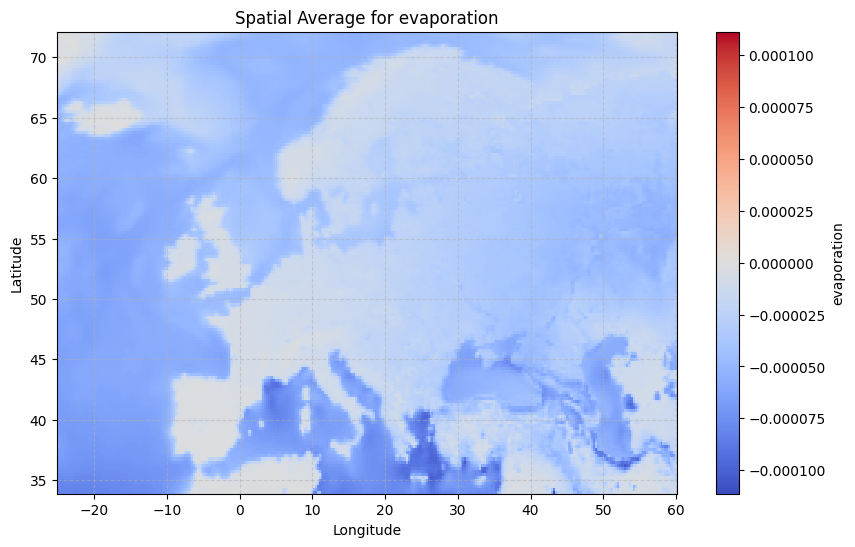

Extreme regions for evaporation:
 <xarray.DataArray 'evaporation' (latitude: 153, longitude: 341)> Size: 52kB
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * latitude   (latitude) float64 1kB 34.0 34.25 34.5 34.75 ... 71.5 71.75 72.0
  * longitude  (longitude) float64 3kB -25.0 -24.75 -24.5 ... 59.5 59.75 60.0
    number     int32 4B 0
    surface    float64 8B 0.0


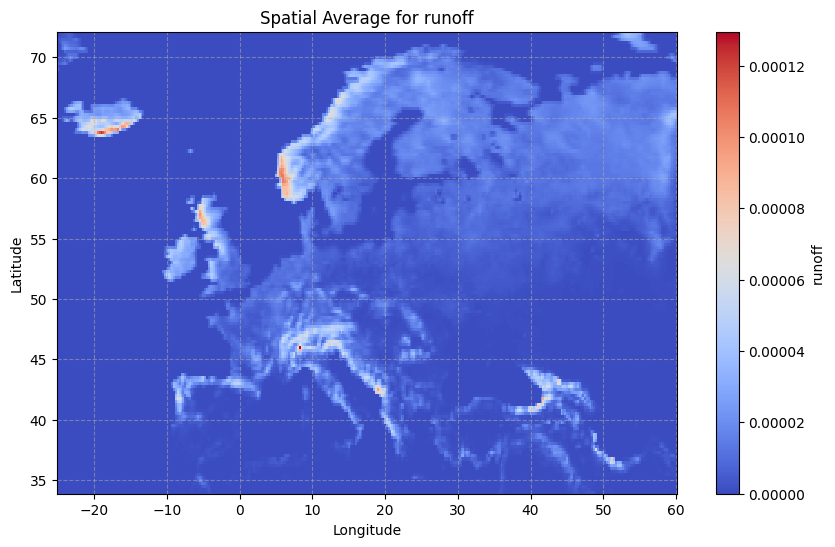

Extreme regions for runoff:
 <xarray.DataArray 'runoff' (latitude: 153, longitude: 341)> Size: 52kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * latitude   (latitude) float64 1kB 34.0 34.25 34.5 34.75 ... 71.5 71.75 72.0
  * longitude  (longitude) float64 3kB -25.0 -24.75 -24.5 ... 59.5 59.75 60.0
    number     int32 4B 0
    surface    float64 8B 0.0


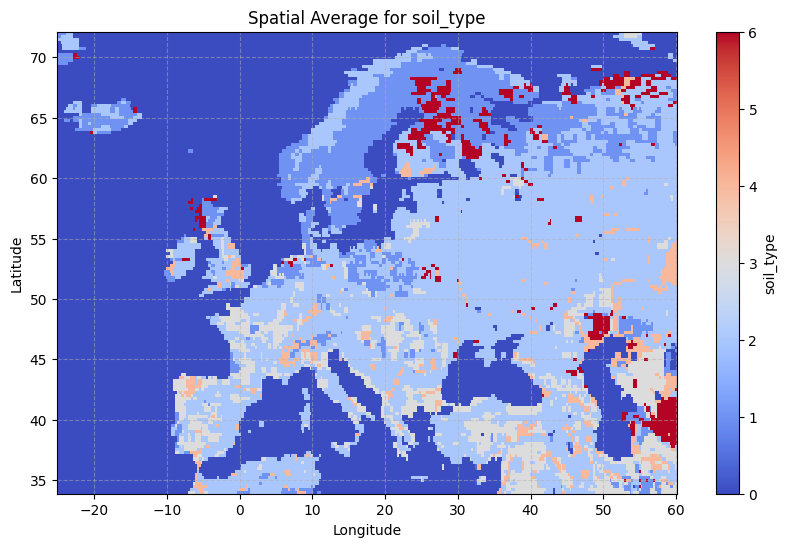

Extreme regions for soil_type:
 <xarray.DataArray 'soil_type' (latitude: 153, longitude: 341)> Size: 52kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * latitude   (latitude) float64 1kB 34.0 34.25 34.5 34.75 ... 71.5 71.75 72.0
  * longitude  (longitude) float64 3kB -25.0 -24.75 -24.5 ... 59.5 59.75 60.0
    number     int32 4B 0
    step       timedelta64[ns] 8B 00:00:00
    surface    float64 8B 0.0


In [72]:
# Analyze spatial averages for each variable
for var in variables_of_interest:
    for ds in processed_datasets:
        if var in ds.variables:
            # Reduce to average over non-lat/lon dimensions
            reduced_var = ds[var].mean(dim=[dim for dim in ds[var].dims if dim not in {"latitude", "longitude"}])
            
            # Check if the variable has latitude and longitude
            if "latitude" in reduced_var.dims and "longitude" in reduced_var.dims:
                # Plot the spatial average
                plt.figure(figsize=(10, 6))
                reduced_var.plot(cmap="coolwarm", cbar_kwargs={"label": var})
                plt.title(f"Spatial Average for {var}")
                plt.xlabel("Longitude")
                plt.ylabel("Latitude")
                plt.grid(True, linestyle="--", alpha=0.5)
                plt.show()

                # Identify extreme regions
                spatial_std = reduced_var.std()
                extreme_mask = (reduced_var > (reduced_var.mean() + 2 * spatial_std)) | (
                    reduced_var < (reduced_var.mean() - 2 * spatial_std)
                )
                print(f"Extreme regions for {var}:\n", extreme_mask)
            else:
                print(f"Skipping {var}: No latitude/longitude information.")


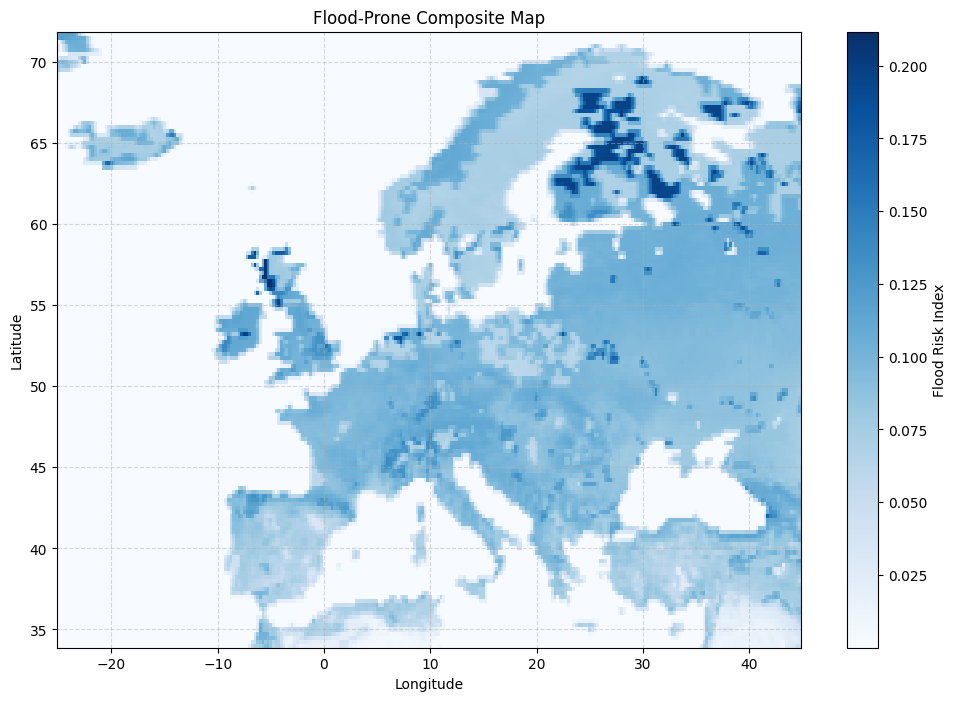

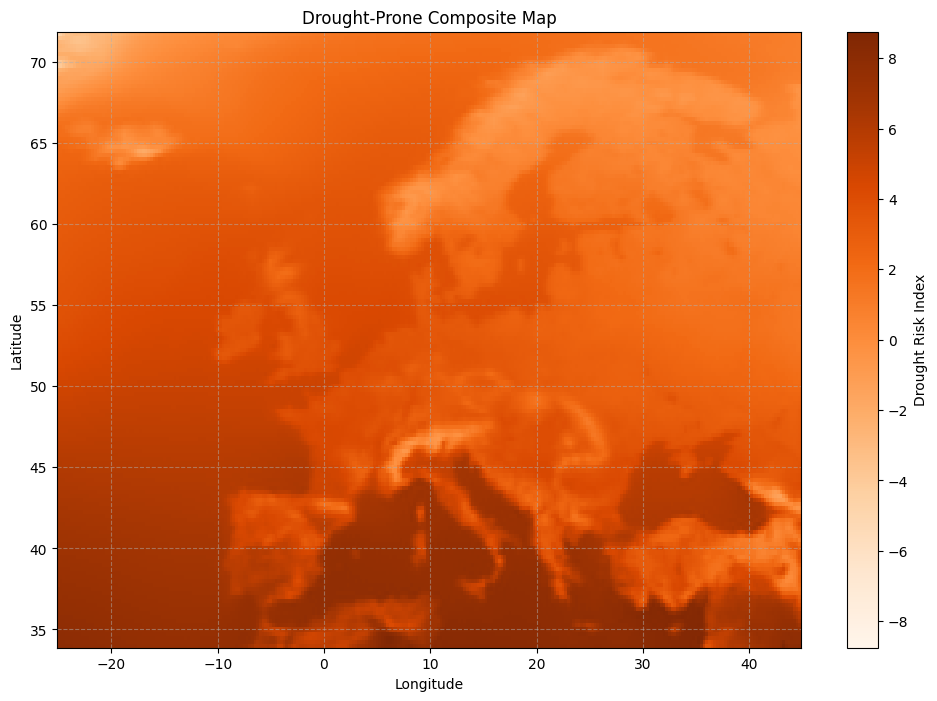

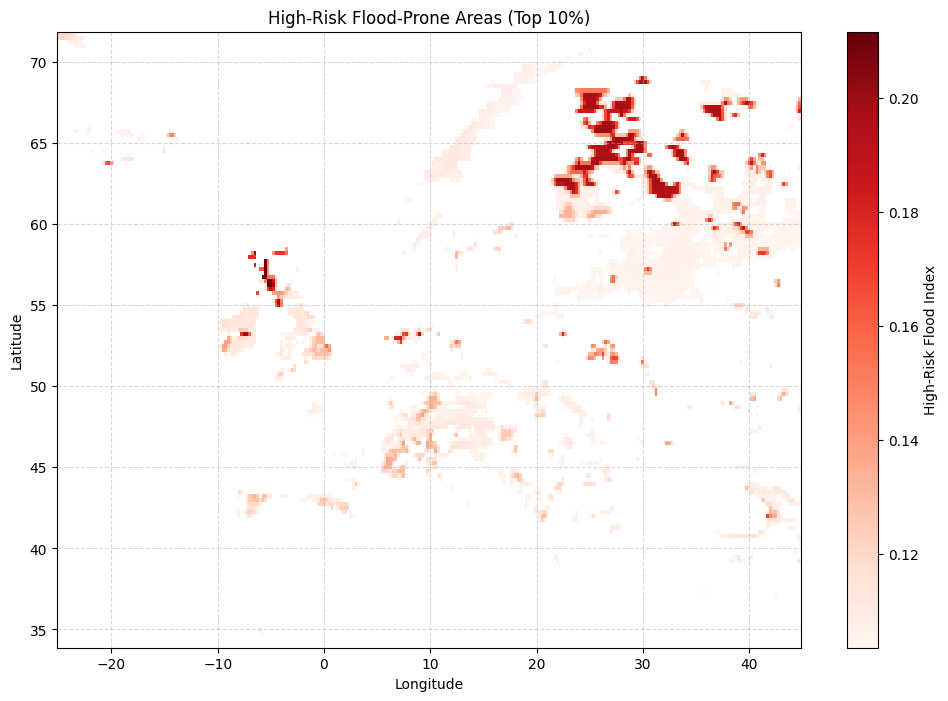

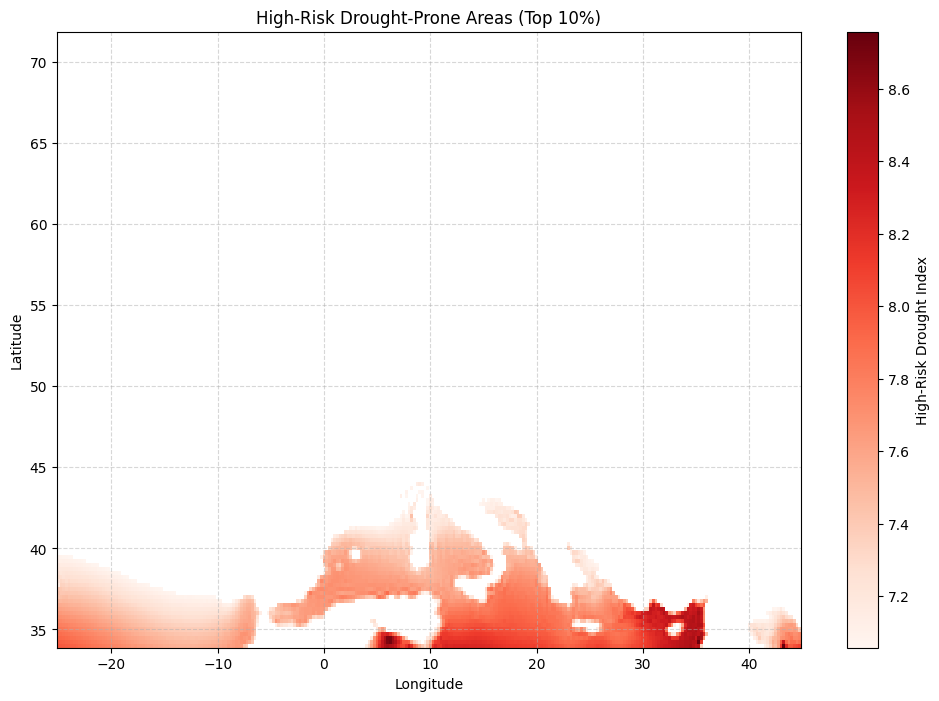

In [65]:
# Weights for flood-prone and drought-prone maps
flood_weights = {
    "total_precipitation": 0.5,
    "volumetric_soil_water_layer_1": 0.3,
    "runoff": 0.2,
}

drought_weights = {
    "temperature_2m": 0.4,
    "potential_evaporation": 0.3,
    "volumetric_soil_water_layer_1": 0.3,
}

# Ensure latitude and longitude are sorted in all datasets
for i, ds in enumerate(processed_datasets):
    if "latitude" in ds.dims:
        processed_datasets[i] = ds.sortby("latitude")
    if "longitude" in ds.dims:
        processed_datasets[i] = ds.sortby("longitude")

# Generate flood-prone map
flood_composite_map = None
for var, weight in flood_weights.items():
    for ds in processed_datasets:
        if var in ds.variables:
            reduced_var = ds[var].mean(dim=[dim for dim in ds[var].dims if dim not in {"latitude", "longitude"}])
            if "latitude" in reduced_var.dims and "longitude" in reduced_var.dims:
                weighted_map = reduced_var * weight
                if flood_composite_map is None:
                    flood_composite_map = weighted_map
                else:
                    flood_composite_map += weighted_map

# Generate drought-prone map
drought_composite_map = None
for var, weight in drought_weights.items():
    for ds in processed_datasets:
        if var in ds.variables:
            reduced_var = ds[var].mean(dim=[dim for dim in ds[var].dims if dim not in {"latitude", "longitude"}])
            if "latitude" in reduced_var.dims and "longitude" in reduced_var.dims:
                weighted_map = reduced_var * weight
                if drought_composite_map is None:
                    drought_composite_map = weighted_map
                else:
                    drought_composite_map += weighted_map

# Interpolate maps for complete spatial coverage
if flood_composite_map is not None:
    flood_composite_map = flood_composite_map.interpolate_na(dim="latitude", method="linear")
    flood_composite_map = flood_composite_map.interpolate_na(dim="longitude", method="linear")
    common_lat = np.arange(34, 72, 0.25)
    common_lon = np.arange(-25, 45, 0.25)
    flood_composite_map = flood_composite_map.interp(latitude=common_lat, longitude=common_lon)

if drought_composite_map is not None:
    drought_composite_map = drought_composite_map.interpolate_na(dim="latitude", method="linear")
    drought_composite_map = drought_composite_map.interpolate_na(dim="longitude", method="linear")
    common_lat = np.arange(34, 72, 0.25)
    common_lon = np.arange(-25, 45, 0.25)
    drought_composite_map = drought_composite_map.interp(latitude=common_lat, longitude=common_lon)

# Plot flood-prone composite map
if flood_composite_map is not None:
    plt.figure(figsize=(12, 8))
    flood_composite_map.plot(cmap="Blues", cbar_kwargs={"label": "Flood Risk Index"})
    plt.title("Flood-Prone Composite Map")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# Plot drought-prone composite map
if drought_composite_map is not None:
    plt.figure(figsize=(12, 8))
    drought_composite_map.plot(cmap="Oranges", cbar_kwargs={"label": "Drought Risk Index"})
    plt.title("Drought-Prone Composite Map")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# Analyze high-risk flood-prone areas
if flood_composite_map is not None:
    high_risk_flood_areas = flood_composite_map.where(flood_composite_map > flood_composite_map.quantile(0.9), drop=False)
    plt.figure(figsize=(12, 8))
    high_risk_flood_areas.plot(cmap="Reds", cbar_kwargs={"label": "High-Risk Flood Index"})
    plt.title("High-Risk Flood-Prone Areas (Top 10%)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# Analyze high-risk drought-prone areas
if drought_composite_map is not None:
    high_risk_drought_areas = drought_composite_map.where(drought_composite_map > drought_composite_map.quantile(0.9), drop=False)
    plt.figure(figsize=(12, 8))
    high_risk_drought_areas.plot(cmap="Reds", cbar_kwargs={"label": "High-Risk Drought Index"})
    plt.title("High-Risk Drought-Prone Areas (Top 10%)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

#### Event Identification and Analysis for Flood


Analyzing total_precipitation for extreme events...
Threshold for extreme events in total_precipitation: 5.795405013486743e-05
Number of extreme events for total_precipitation: 7

Analyzing temperature_2m for extreme events...
Threshold for extreme events in temperature_2m: 15.951091766357422
Number of extreme events for temperature_2m: 7

Analyzing runoff for extreme events...
Threshold for extreme events in runoff: 7.3896442245313665e-06
Number of extreme events for runoff: 7


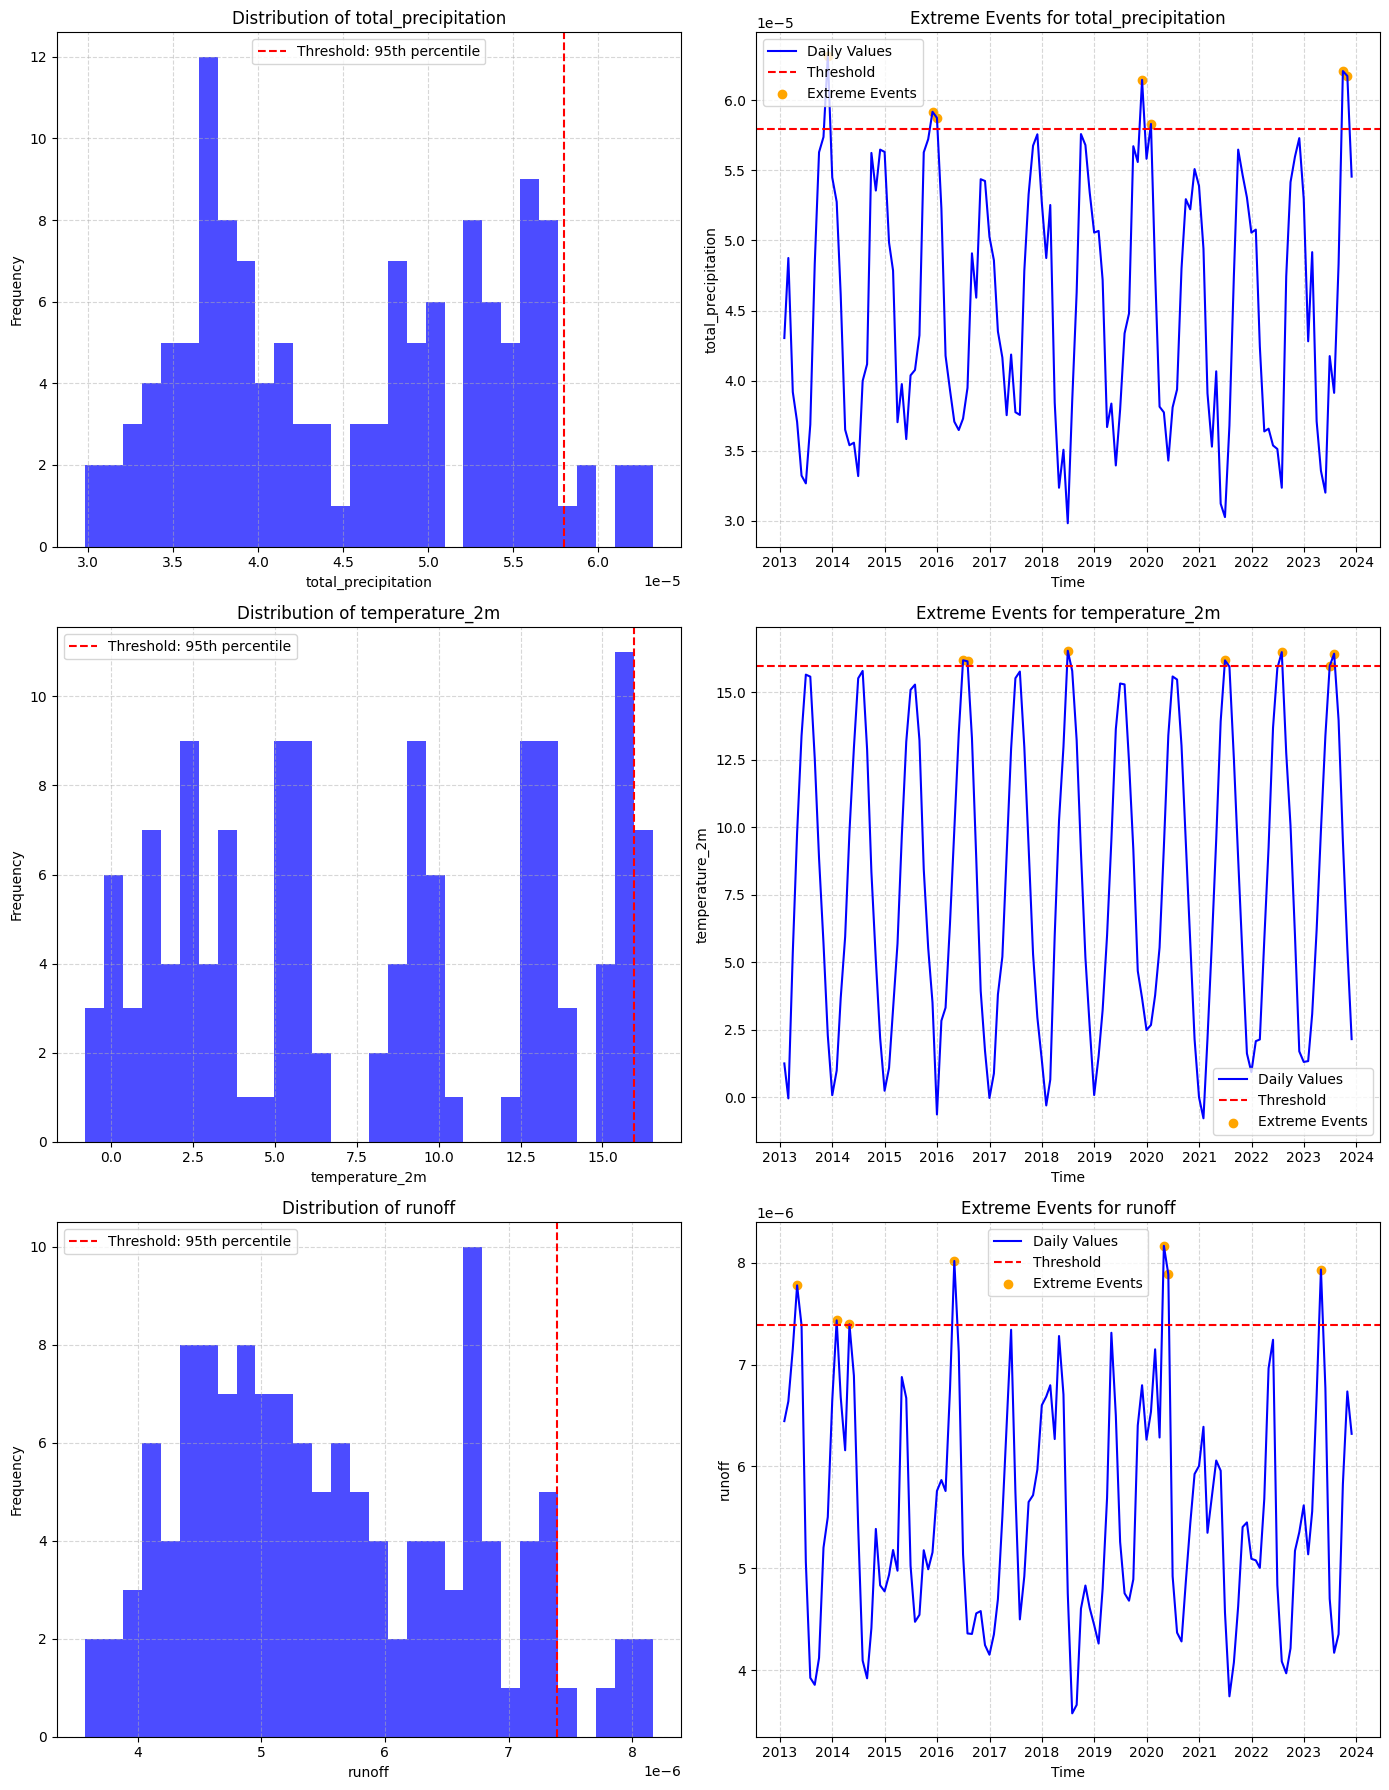

In [113]:
# Variables to analyze
variables_to_analyze = ["total_precipitation", "temperature_2m", "runoff"]

# Create a 3x2 grid for plotting
fig, axes = plt.subplots(3, 2, figsize=(14, 18))  # 3 rows, 2 columns of plots
axes = axes.flatten()  # Convert the 2D grid of axes into a 1D array for easy access

for i, variable in enumerate(variables_to_analyze):
    # Check if the variable exists in the data
    if variable in filtered_data.columns:
        print(f"\nAnalyzing {variable} for extreme events...")

        # Calculate the threshold for extreme events (95th percentile)
        threshold = filtered_data[variable].quantile(0.95)
        print(f"Threshold for extreme events in {variable}: {threshold}")

        # Find values that are above the threshold
        extreme_events = filtered_data[filtered_data[variable] > threshold]
        print(f"Number of extreme events for {variable}: {len(extreme_events)}")

        # Plot the distribution of the variable
        ax = axes[i * 2]  # Left plot in the row
        ax.hist(filtered_data[variable], bins=30, color='blue', alpha=0.7)
        ax.axvline(threshold, color='red', linestyle='--', label=f"Threshold: 95th percentile")
        ax.set_title(f"Distribution of {variable}")
        ax.set_xlabel(variable)
        ax.set_ylabel("Frequency")
        ax.legend()
        ax.grid(True, linestyle="--", alpha=0.5)

        # Plot the time-series data with extreme events
        ax = axes[i * 2 + 1]  # Right plot in the row
        ax.plot(filtered_data[variable], label="Daily Values", color="blue")
        ax.axhline(threshold, color="red", linestyle="--", label="Threshold")
        ax.scatter(extreme_events.index, extreme_events[variable], color="orange", label="Extreme Events")
        ax.set_title(f"Extreme Events for {variable}")
        ax.set_xlabel("Time")
        ax.set_ylabel(variable)
        ax.legend()
        ax.grid(True, linestyle="--", alpha=0.5)

        # Format the x-axis to show years clearly
        ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Show one tick per year
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    else:
        print(f"The variable '{variable}' does not exist in the dataset.")

# Adjust layout to prevent overlap and show the plots
plt.tight_layout()
plt.show()


#### Event Identification and Analysis for Drought


Analyzing temperature_2m for drought-related extreme events...
Threshold for drought events in temperature_2m: 15.951091766357422
Number of drought-related extreme events for temperature_2m: 7

Analyzing potential_evaporation for drought-related extreme events...
Threshold for drought events in potential_evaporation: -1.9976404246335733e-06
Number of drought-related extreme events for potential_evaporation: 7

Analyzing volumetric_soil_water_layer_1 for drought-related extreme events...
Threshold for drought events in volumetric_soil_water_layer_1: 0.12569228559732437
Number of drought-related extreme events for volumetric_soil_water_layer_1: 7


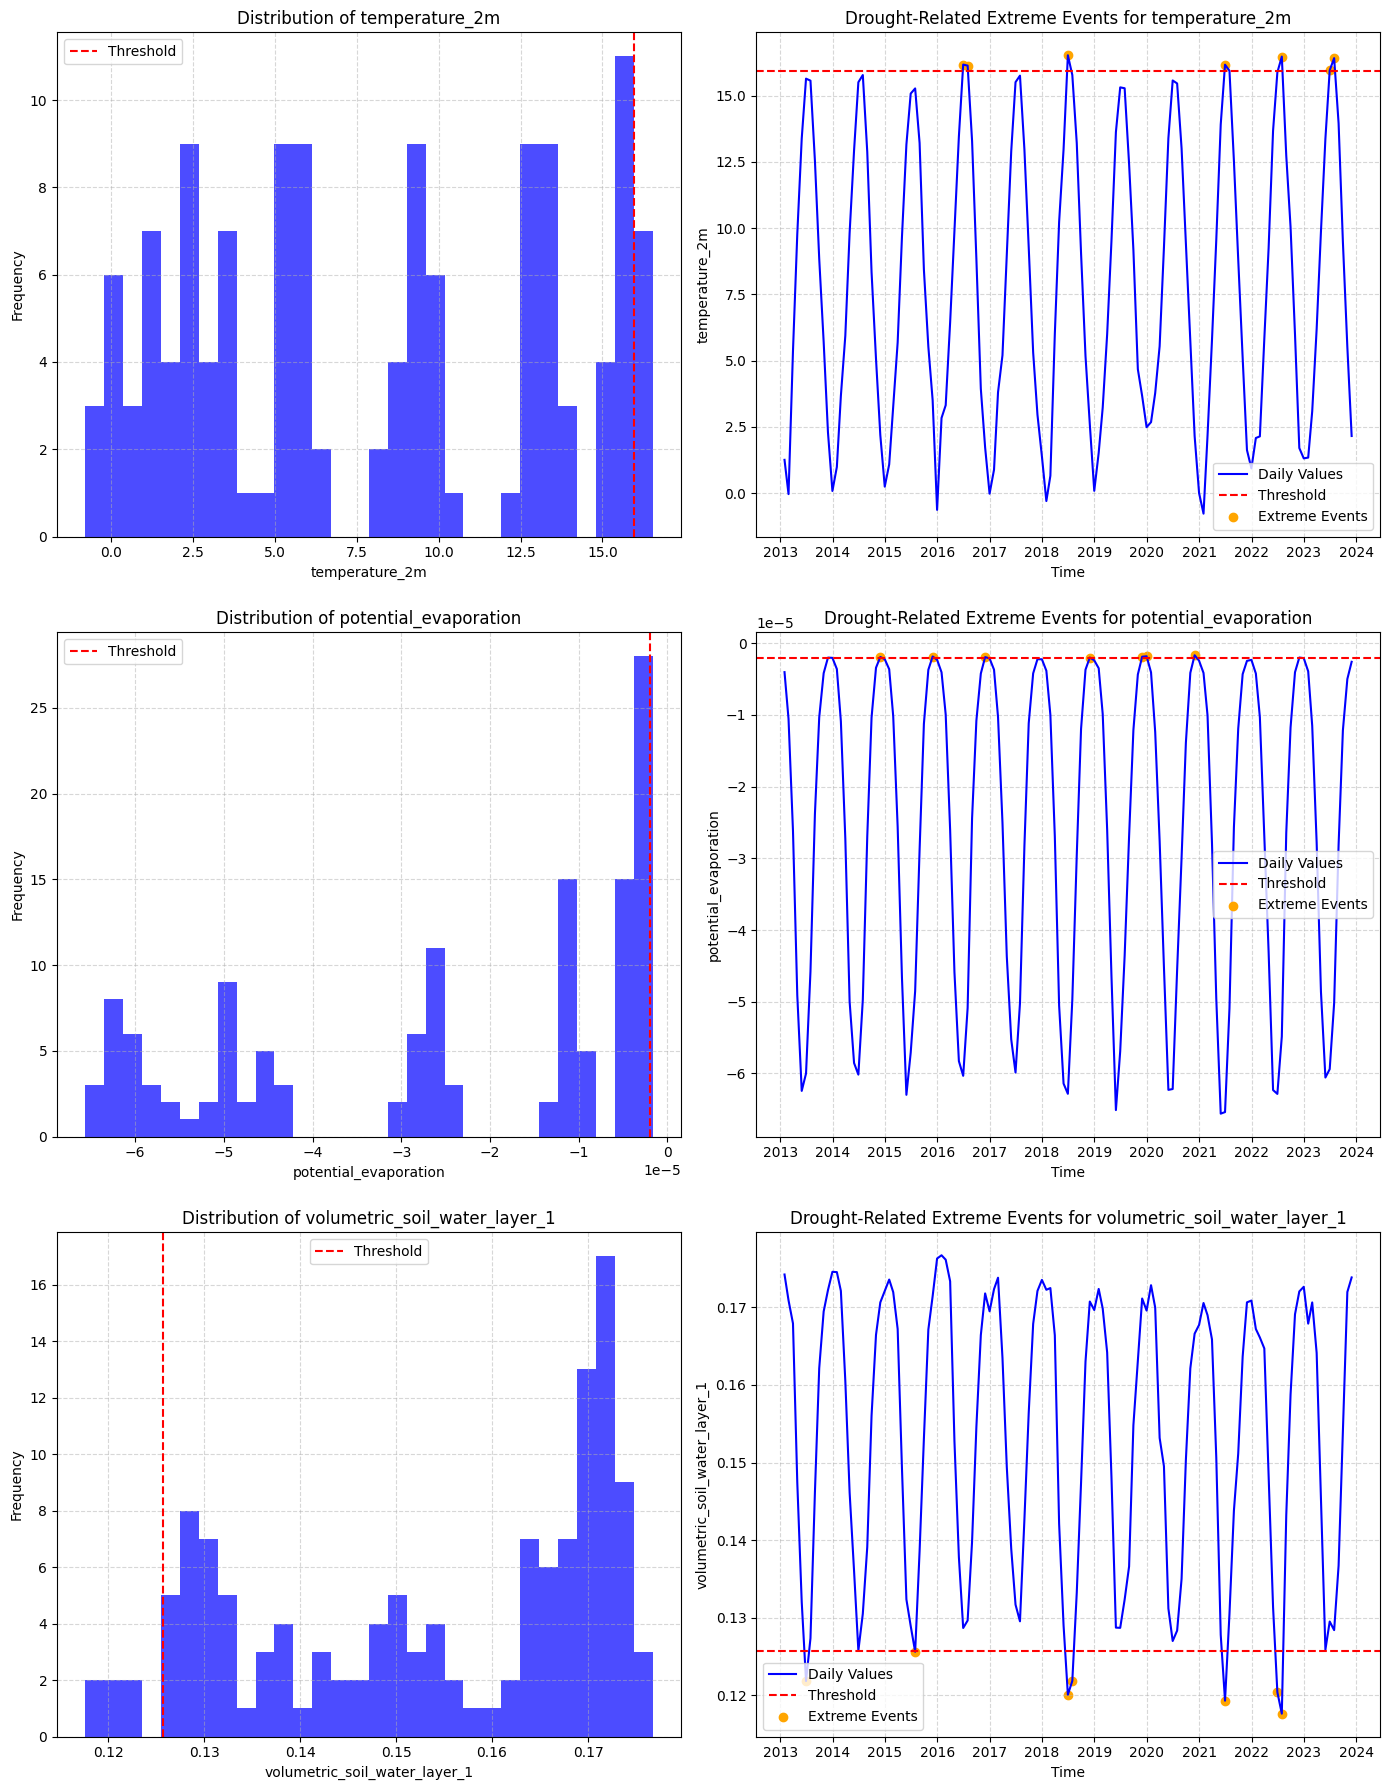

In [114]:
# Variables to analyze for drought
drought_variables = ["temperature_2m", "potential_evaporation", "volumetric_soil_water_layer_1"]

# Create a 3x2 grid for plotting
fig, axes = plt.subplots(3, 2, figsize=(14, 18))  # 3 rows, 2 columns of plots
axes = axes.flatten()  # Convert the 2D grid of axes into a 1D array for easy access

for i, variable in enumerate(drought_variables):
    # Check if the variable exists in the data
    if variable in filtered_data.columns:
        print(f"\nAnalyzing {variable} for drought-related extreme events...")

        # Calculate the threshold for extreme drought events (5th percentile for soil water, 95th for temperature/evaporation)
        if variable == "volumetric_soil_water_layer_1":
            threshold = filtered_data[variable].quantile(0.05)  # Lower values indicate drought
            comparison_operator = "<"  # For soil water, drought means values below the threshold
        else:
            threshold = filtered_data[variable].quantile(0.95)  # Higher values indicate drought
            comparison_operator = ">"  # For temperature/evaporation, drought means values above the threshold

        print(f"Threshold for drought events in {variable}: {threshold}")

        # Find drought events
        if comparison_operator == ">":
            extreme_events = filtered_data[filtered_data[variable] > threshold]
        else:
            extreme_events = filtered_data[filtered_data[variable] < threshold]

        print(f"Number of drought-related extreme events for {variable}: {len(extreme_events)}")

        # Plot the distribution of the variable
        ax = axes[i * 2]  # Left plot in the row
        filtered_data[variable].hist(bins=30, color='blue', alpha=0.7, ax=ax)
        ax.axvline(threshold, color='red', linestyle='--', label=f"Threshold")
        ax.set_title(f"Distribution of {variable}")
        ax.set_xlabel(variable)
        ax.set_ylabel("Frequency")
        ax.legend()
        ax.grid(True, linestyle="--", alpha=0.5)

        # Plot the time-series data with drought-related extreme events
        ax = axes[i * 2 + 1]  # Right plot in the row
        ax.plot(filtered_data[variable], label="Daily Values", color="blue")
        ax.axhline(threshold, color="red", linestyle="--", label="Threshold")
        ax.scatter(extreme_events.index, extreme_events[variable], color="orange", label="Extreme Events")
        ax.set_title(f"Drought-Related Extreme Events for {variable}")
        ax.set_xlabel("Time")
        ax.set_ylabel(variable)
        ax.legend()
        ax.grid(True, linestyle="--", alpha=0.5)

        # Format the x-axis to show years clearly
        ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Show one tick per year
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    else:
        print(f"The variable '{variable}' does not exist in the dataset.")

# Adjust layout to prevent overlap and show the plots
plt.tight_layout()
plt.show()


## 2. Multi-model_seasonal_reforecasts_of_river_discharge_for Europe_2013-2020

#### Combine Datasets & Cleaning 

In [117]:

folder_path = r"C:\Users\giann\OneDrive\Desktop\Thesis\Copernicus_Data\Multi-model_seasonal_reforecasts_of_river_discharge_for Europe_2013-2020"

# Find all .nc files in the folder
file_list = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".nc")]

# Fix the 'step' dimension and ensure it's unique
def preprocess(ds):
    if "step" in ds.coords and "valid_time" in ds.coords:
        # Replace 'step' with 'valid_time'
        ds = ds.assign_coords(step=("step", ds["valid_time"].values))
    
    # Deduplicate or aggregate 'step'
    if "step" in ds.coords:
        # Remove duplicates, keeping the first occurrence
        _, index = np.unique(ds["step"], return_index=True)
        # ds = ds.isel(step=index) 
        ds = ds.groupby("step").mean()
    return ds

# Categorize files by member size
files_by_member_size = {25: [], 51: []}

for file in file_list:
    ds = xr.open_dataset(file)
    member_size = ds.sizes.get('member', None)
    if member_size == 25:
        files_by_member_size[25].append(file)
    elif member_size == 51:
        files_by_member_size[51].append(file)

# Combine datasets
combined_datasets = {}

for member_size, files in files_by_member_size.items():
    if files:
        # Use open_mfdataset to process files and reduce memory usage
        
        # Chunking divides the dataset into manageable parts based on one or more dimensions
        # Each "chunk" is a smaller portion of the dataset, and operations are performed on these
        # chunks sequentially or in parallel, which helps reduce memory usage and allows processing 
        # of datasets that are too large to fit into RAM.
        ds = xr.open_mfdataset(
            files,
            preprocess=preprocess,
            combine="nested", #assumes that the files are ordered logically in the same way as the desired concatenation order
            concat_dim="member",
            chunks={"step": 10}  
        )
        
        # Sort the dataset by 'step' in ascending order
        ds = ds.sortby("step", ascending=True)

        
        # Fill missing values
        ds = ds.fillna(float("nan"))  # Replace missing data with NaN
        print(f"Filled missing values for dataset with {member_size} members.")

        # Validate data ranges
        if "discharge" in ds.variables:  # Ensure river discharge is non-negative
            ds["discharge"] = ds["discharge"].where(ds["discharge"] >= 0, float("nan"))
            print("Validated river discharge values (>= 0).")

        if "temperature" in ds.variables:  # Ensure temperature is within a realistic range
            ds["temperature"] = ds["temperature"].where((ds["temperature"] >= 200) & (ds["temperature"] <= 350), float("nan"))
            print("Validated temperature range (200K to 350K).")

        # Convert units
        if "temperature" in ds.variables:  # Convert temperature from Kelvin to Celsius
            ds["temperature"] = ds["temperature"] - 273.15
            print("Converted temperature to Celsius.")

        if "precipitation" in ds.variables:  # Convert precipitation to millimeters
            ds["precipitation"] = ds["precipitation"] * 1000
            print("Converted precipitation to millimeters.")

        # Rename variables for clarity
        rename_dict = {
            "discharge": "river_discharge",
            "temperature": "air_temperature",
            "precipitation": "total_precipitation"
        }
        existing_vars = set(ds.variables)  # Get all variables in the dataset
        rename_vars = {k: v for k, v in rename_dict.items() if k in existing_vars}  # Find variables to rename
        ds = ds.rename(rename_vars)  # Apply the renaming
        print("Renamed variables for clarity.")

        # Update metadata
        for var in ds.data_vars:  # Add descriptions to all variables
            ds[var].attrs["description"] = f"Cleaned variable: {var}"
        print("Updated metadata.")

        
        combined_datasets[member_size] = ds
        print(f"Combined dataset with {member_size} members:")
        print(ds)
    else:
        print(f"No datasets found with {member_size} members.")


Filled missing values for dataset with 25 members.
Renamed variables for clarity.
Updated metadata.
Combined dataset with 25 members:
<xarray.Dataset> Size: 1TB
Dimensions:                       (step: 54, y: 950, x: 1000, member: 1200)
Coordinates:
  * y                             (y) float64 8kB 5.498e+06 ... 7.525e+05
  * x                             (x) float64 8kB 2.502e+06 ... 7.498e+06
  * step                          (step) datetime64[ns] 432B 2013-01-31 ... 2...
    number                        (member) int64 10kB dask.array<chunksize=(25,), meta=np.ndarray>
Dimensions without coordinates: member
Data variables:
    rdis                          (step, y, x, member) float32 246GB dask.array<chunksize=(1, 950, 1000, 25), meta=np.ndarray>
    latitude                      (member, step, y, x) float32 246GB dask.array<chunksize=(25, 1, 950, 1000), meta=np.ndarray>
    longitude                     (member, step, y, x) float32 246GB dask.array<chunksize=(25, 1, 950, 1000), met

## 3. Multi-model_seasonal_reforecasts_of_river_discharge_for Europe_2021-2023

#### Load & Exploring Dataset

In [13]:
folder_path = r"C:\Users\giann\OneDrive\Desktop\Thesis\Copernicus_Data\Multi-model_seasonal_reforecasts_of_river_discharge_for Europe_2021-2023"

# Get the list of all .nc files in the folder
file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(".nc")]

# Go through each file and show its dimensions
for idx, file_path in enumerate(file_list):
    try:
        # Open the dataset
        ds = xr.open_dataset(file_path)
        
        # Print the file name and its dimensions
        print(f"Dataset {idx + 1}: {os.path.basename(file_path)}")
        print(ds.dims)  # Show dataset dimensions
        print("-" * 40)  # Add a separator for clarity

        
        # Close the dataset to free space in memory
        ds.close()
    except Exception as e:
        print(f"Error reading {file_path}: {e}")


Dataset 1: fairCRPSS_seas5_EFAS_01_v1.nc
FrozenMappingWarningOnValuesAccess({'time': 1, 'step': 7, 'y': 950, 'x': 1000})
----------------------------------------
Dataset 2: fairCRPSS_seas5_EFAS_02_v1.nc
FrozenMappingWarningOnValuesAccess({'time': 1, 'step': 7, 'y': 950, 'x': 1000})
----------------------------------------
Dataset 3: fairCRPSS_seas5_EFAS_03_v1.nc
FrozenMappingWarningOnValuesAccess({'time': 1, 'step': 7, 'y': 950, 'x': 1000})
----------------------------------------
Dataset 4: fairCRPSS_seas5_EFAS_04_v1.nc
FrozenMappingWarningOnValuesAccess({'time': 1, 'step': 7, 'y': 950, 'x': 1000})
----------------------------------------
Dataset 5: fairCRPSS_seas5_EFAS_05_v1.nc
FrozenMappingWarningOnValuesAccess({'time': 1, 'step': 7, 'y': 950, 'x': 1000})
----------------------------------------
Dataset 6: fairCRPSS_seas5_EFAS_06_v1.nc
FrozenMappingWarningOnValuesAccess({'time': 1, 'step': 7, 'y': 950, 'x': 1000})
----------------------------------------
Dataset 7: fairCRPSS_seas5_E

#### Combine Datasets & Cleaning 

In [14]:

# Path to the folder with all .nc files
folder_path = r"C:\Users\giann\OneDrive\Desktop\Thesis\Copernicus_Data\Multi-model_seasonal_reforecasts_of_river_discharge_for Europe_2021-2023"

# Get a list of all .nc files in the folder
file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(".nc")]

# Function to clean and prepare each dataset
def preprocess(ds):
    # Make sure 'longitude' and 'latitude' are treated as coordinates
    if "longitude" not in ds.coords and "longitude" in ds.variables:
        ds = ds.set_coords("longitude")
    if "latitude" not in ds.coords and "latitude" in ds.variables:
        ds = ds.set_coords("latitude")

    # If 'step' is missing, create it from 'time'
    if "step" not in ds.sizes and "time" in ds.sizes:
        ds["step"] = ("time", np.arange(ds.sizes["time"]))  # Add step values
        ds = ds.swap_dims({"time": "step"})  # Use 'step' instead of 'time'

    # Convert 'step' values to days
    if "step" in ds.coords:
        step_values = ds["step"].values
        step_values_in_days = (step_values - step_values.min()) / (60 * 60 * 24 * 1e9)  # Convert to days
        ds = ds.assign_coords(step=("step", step_values_in_days.astype("float64")))
        ds = ds.sortby("step")  # Sort steps by value

    # Replace missing values with 0
    ds = ds.fillna(0)

    # Remove duplicate steps
    if "step" in ds.dims:
        _, index = np.unique(ds["step"], return_index=True)
        ds = ds.isel(step=index)

    # Make sure values are within reasonable ranges
    for var in ds.data_vars:
        ds[var] = ds[var].clip(min=0)  # Set all negative values to 0

    # Remove outliers (extreme values)
    for var in ds.data_vars:
        if isinstance(ds[var].data, np.ndarray):  # Only apply if not using dask
            lower = ds[var].quantile(0.01).compute()
            upper = ds[var].quantile(0.99).compute()
            ds[var] = ds[var].where((ds[var] >= lower) & (ds[var] <= upper), np.nan)

    # Make sure latitude and longitude values are valid
    if "latitude" in ds.coords and "longitude" in ds.coords:
        valid_lat = (ds["latitude"] >= -90) & (ds["latitude"] <= 90)
        valid_lon = (ds["longitude"] >= -180) & (ds["longitude"] <= 180)
        ds = ds.where(valid_lat.compute() & valid_lon.compute(), drop=True)  # Keep only valid coordinates

    # Add metadata to show the dataset was cleaned
    ds.attrs["processed"] = "True"
    ds.attrs["description"] = "Cleaned dataset with missing values fixed and outliers removed."

    return ds

# Function to combine multiple datasets into one
def combine_datasets(files):
    try:
        # Open and combine datasets
        combined = xr.open_mfdataset(
            files,
            preprocess=preprocess,  # Clean each dataset before combining
            combine="by_coords",    # Match datasets by their coordinates
            chunks={}               # Avoid chunking issues
        )
        # Fix chunking along spatial dimensions to avoid errors
        combined = combined.chunk({"y": -1, "x": -1})
        print("Datasets combined successfully!")
        return combined
    except Exception as e:
        print(f"Error combining datasets: {e}")
        return None

# Combine the first half of the datasets
ds_combined1 = combine_datasets(file_list[:16])  # Process the first set of files
if ds_combined1:
    print("First combined dataset:")
    print(ds_combined1)

# Combine the second half of the datasets
ds_combined2 = combine_datasets(file_list[16:])  # Process the second set of files
if ds_combined2:
    print("Second combined dataset:")
    print(ds_combined2)

Datasets combined successfully!
First combined dataset:
<xarray.Dataset> Size: 5GB
Dimensions:                       (time: 1, y: 950, x: 1000, step: 24,
                                   member: 51)
Coordinates:
  * time                          (time) datetime64[ns] 8B 2016-01-01
  * y                             (y) int32 4kB 5497500 5492500 ... 752500
  * x                             (x) int32 4kB 2502500 2507500 ... 7497500
  * step                          (step) float64 192B -8.031e+04 ... 9.956e+04
    latitude                      (y, x) float32 4MB dask.array<chunksize=(950, 1000), meta=np.ndarray>
    longitude                     (y, x) float32 4MB dask.array<chunksize=(950, 1000), meta=np.ndarray>
    number                        (member) int64 408B dask.array<chunksize=(51,), meta=np.ndarray>
    valid_time                    (step) datetime64[ns] 192B dask.array<chunksize=(7,), meta=np.ndarray>
Dimensions without coordinates: member
Data variables:
    fairCRPSS      

## New Attemp

In [118]:
# import os
# import xarray as xr

# # Specify the folder path
# folder_path = r"C:\Users\giann\OneDrive\Desktop\Thesis\Copernicus_Data\Multi-model_seasonal_reforecasts_of_river_discharge_for Europe_2021-2023"

# # Get the list of all .nc files in the folder
# file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(".nc")]

# # Initialize an empty list to store datasets
# datasets = []

# # Loop through each file
# for idx, file_path in enumerate(file_list):
#     try:
#         # Open the dataset
#         ds = xr.open_dataset(file_path)
        
#         # Print the Dataset name, dimensions, and variables
#         print(f"Dataset {idx + 1}: {os.path.basename(file_path)}")
#         print("Dimensions:", ds.dims)  # Show dataset dimensions
#         print("Variables:", list(ds.data_vars.keys()))  # List of variables
#         print("-" * 40)  # Add a separator for clarity

#         # Append the dataset to the list
#         datasets.append(ds)
#     except Exception as e:
#         print(f"Error reading {file_path}: {e}")

In [119]:
# # Dictionary to store datasets by year
# datasets_by_year = {}

# # Process each file and split by year
# for file_path in file_list:
#     try:
#         ds = xr.open_dataset(file_path, chunks={'x': 100, 'y': 100})  # Use Dask for lazy loading with chunking

#         # Ensure 'rdis' is numeric
#         if "rdis" in ds.variables:
#             if not pd.api.types.is_numeric_dtype(ds["rdis"].dtype):
#                 ds["rdis"] = ds["rdis"].astype(float)

#             # Convert TimeDelta64 variables to float64
#             for var in ds.variables:
#                 if ds[var].dtype.kind == 'm':  # Check for timedelta64 type
#                     ds[var] = ds[var].astype(float)  # Convert to float64

#             # Handle the 'step' dimension as time
#             if "step" in ds.dims:
#                 # Extract the filename and parse the base date
#                 filename = os.path.basename(file_path)
#                 try:
#                     base_date_str = filename.split("_")[3]  # Adjust index based on filename structure
#                     base_date = pd.to_datetime(base_date_str, format='%Y%m%d')
#                 except (IndexError, ValueError) as e:
#                     print(f"Invalid date format in file name: {file_path}. Error: {e}")
#                     continue

#                 # Use ds.sizes to get the length of the 'step' dimension
#                 step_values = pd.date_range(start=base_date, periods=ds.sizes["step"], freq='D')
#                 ds = ds.assign_coords(time=("step", step_values))
#                 ds = ds.swap_dims({"step": "time"})

#             # Drop inconsistent coordinates if present
#             ds = ds.reset_coords(names=["latitude", "longitude"], drop=True)

#             # Extract the year from the file name
#             year = base_date.year

#             # Add the dataset to the corresponding year in the dictionary
#             if year not in datasets_by_year:
#                 datasets_by_year[year] = []
#             datasets_by_year[year].append(ds)

#     except Exception as e:
#         print(f"Error reading {file_path}: {e}")

# # Combine datasets for each year
# combined_datasets_by_year = {}
# for year, datasets in datasets_by_year.items():
#     try:
#         combined_dataset = xr.concat(
#             datasets,
#             dim="time",
#             coords="minimal",
#             compat="override",
#             combine_attrs="override"
#         )

#         # Calculate mean `rdis` for each combination of `y`, `x`, and `time`, ignoring NaN values
#         reduced_dataset = (
#             combined_dataset["rdis"]
#             .groupby(["y", "x", "time"])
#             .mean(dim="member", skipna=True)
#         )
        
#         # Add back reduced `rdis` to the dataset
#         reduced_dataset = reduced_dataset.to_dataset(name="rdis")
        
#         # Save reduced dataset
#         combined_datasets_by_year[year] = reduced_dataset.chunk({"time": 10, "x": 100, "y": 100})
#         print(f"Datasets for year {year} reduced and combined successfully.")
#     except Exception as e:
#         print(f"Error combining datasets for year {year}: {e}")


#### Convert to a DataFrame

In [120]:
# import dask.dataframe as dd

# # Convert to Dask DataFrame
# try:
#     dask_df = combined_group_3["rdis"].to_dask_dataframe()
    
#     # Drop unused columns
#     dask_df = dask_df.drop(columns=["step", "valid_time"])
#     print("Dataset successfully deleted columns to a Dask DataFrame.")

#     # Example: Calculate mean `rdis` for specific columns without loading the full dataset
#     grouped_df = dask_df.groupby(["y", "x", "time"])["rdis"].mean().compute()
#     print("Grouped mean calculation completed.")

# except Exception as e:
#     print(f"Error processing dataset: {e}")


In [121]:
# # Ensure 'rdis' exists in the dataset
# if "rdis" in df_filtered.columns:
#     print("\nAnalyzing 'rdis' for extreme events...")

#     # Step 1: Filter out low or insignificant values (e.g., rdis <= 1)
#     valid_rdis = df_filtered[df_filtered['rdis'] > 10]  # Filter out values <= 10

#     # # Ensure the index is a datetime index using 'valid_time'
#     # if 'valid_time' in valid_rdis.columns:
#     #     valid_rdis['valid_time'] = pd.to_datetime(valid_rdis['valid_time'])  # Convert 'valid_time' to datetime
#     #     valid_rdis.set_index('valid_time', inplace=True)  # Set as the index

#     print(f"Valid data count after ignoring low values: {len(valid_rdis)}")

#     # Step 2: Calculate the threshold for extreme events (95th percentile)
#     threshold = valid_rdis['rdis'].quantile(0.95)
#     print(f"95th percentile threshold for 'rdis': {threshold}")

#     # Step 3: Identify extreme events (values above the threshold)
#     extreme_events = valid_rdis[valid_rdis['rdis'] > threshold]
#     print(f"Number of extreme events for 'rdis': {len(extreme_events)}")

#     # Create a 1x2 grid for plotting
#     fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns of plots

#     # Step 4: Plot the distribution of the variable (ignoring insignificant values)
#     ax = axes[0]  # Left plot in the row
#     ax.hist(valid_rdis['rdis'], bins=30, color='blue', alpha=0.7)
#     ax.axvline(threshold, color='red', linestyle='--', label=f"Threshold: 95th percentile")
#     ax.set_title(f"Distribution of 'rdis' (filtered values > 10)")
#     ax.set_xlabel("rdis")
#     ax.set_ylabel("Frequency")
#     ax.legend()
#     ax.grid(True, linestyle="--", alpha=0.5)

#     # Step 5: Plot the time-series data with extreme events
#     ax = axes[1]  # Right plot in the row
#     ax.plot(valid_rdis.index, valid_rdis['rdis'], label="Daily Values", color="blue")
#     ax.axhline(threshold, color='red', linestyle="--", label="Threshold")
#     ax.scatter(extreme_events.index, extreme_events['rdis'], color="orange", label="Extreme Events")
#     ax.set_title(f"Extreme Events for 'rdis' (filtered values > 10)")
#     ax.set_xlabel("Valid Time")
#     ax.set_ylabel("rdis")
#     ax.legend()
#     ax.grid(True, linestyle="--", alpha=0.5)

#     # Format the x-axis to show years clearly
#     ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Show one tick per year
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

#     # Adjust layout to prevent overlap and show the plots
#     plt.tight_layout()
#     plt.show()
# else:
#     print(f"The variable 'rdis' does not exist in the dataset.")


## 4. Climate_indicators_for_Europe_from_2013_to_2023_derived_from_reanalysis

#### Combine Datasets

In [24]:
# Define the folder path containing .nc files
folder_path = r"C:\Users\giann\OneDrive\Desktop\Thesis\Copernicus_Data\Climate_indicators_for_Europe_from_2013_to_2023_derived_from_reanalysis"

# Find all .nc files in the folder
file_list = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".nc")]

# Open and combine datasets using Dask with adjustable chunking
print("Opening datasets...")

chunk_sizes = {
    "step": 20,         # Adjust this based on the total number of steps
    "latitude": 100,    # Adjust this based on the spatial resolution
    "longitude": 100    # Adjust this based on the spatial resolution
}

combined_dataset = xr.open_mfdataset(
    file_list,
    combine='nested',
    concat_dim='step',
    coords='minimal',
    chunks=chunk_sizes  # Use optimized chunk sizes
)
print("Datasets combined successfully with adjusted chunking!")

Opening datasets...
Datasets combined successfully with adjusted chunking!


#### Data Cleaning

In [25]:
# Define time ranges for segmentation
time_segments = [
    ("2013-01-01", "2018-12-31"),
    ("2019-01-01", "2023-12-31")
]

# Dictionary to store segment datasets
segment_datasets = {}

# Process and analyze each time segment
for start_date, end_date in time_segments:
    print(f"\nProcessing and analyzing data for {start_date} to {end_date}...")

    # Filter data by time
    segment_dataset = combined_dataset.sel(time=slice(start_date, end_date))

    # Cleaning process
    segment_dataset = segment_dataset.fillna(float("nan"))  # Replace missing values with NaN

    # Clean 2-metre temperature (t2m)
    if "t2m" in segment_dataset.variables:
        segment_dataset["t2m"] = segment_dataset["t2m"].where(
            (segment_dataset["t2m"] >= 200) & (segment_dataset["t2m"] <= 350), float("nan")
        )
        segment_dataset["t2m"] = segment_dataset["t2m"] - 273.15  # Convert from Kelvin to Celsius
        segment_dataset["t2m"].attrs["units"] = "Celsius"
        print("Validated and converted 2-metre temperature (t2m).")

    # Clean total precipitation (tp)
    if "tp" in segment_dataset.variables:
        segment_dataset["tp"] = segment_dataset["tp"].where(
            segment_dataset["tp"] >= 0, float("nan")
        )
        segment_dataset["tp"] = segment_dataset["tp"] * 1000  # Convert to millimeters
        segment_dataset["tp"].attrs["units"] = "mm"
        print("Validated and converted total precipitation (tp).")

    # Clean Fire Weather Index (fwi)
    if "fwi" in segment_dataset.variables:
        segment_dataset["fwi"] = segment_dataset["fwi"].where(
            segment_dataset["fwi"] >= 0, float("nan")
        )
        print("Validated Fire Weather Index (fwi): values >= 0.")

    # Clean Cooling Degree Days (cdd)
    if "cdd" in segment_dataset.variables:
        segment_dataset["cdd"] = segment_dataset["cdd"].where(
            segment_dataset["cdd"] >= 0, float("nan")
        )
        print("Validated Cooling Degree Days (cdd): values >= 0.")

    # Rename variables for clarity
    rename_dict = {
        "fwi": "fire_weather_index",
        "tp": "total_precipitation",
        "cdd": "cooling_degree_days",
        "t2m": "2_metre_temperature"
    }
    # Rename variable names for clarity
    segment_dataset = segment_dataset.rename({k: v for k, v in rename_dict.items() if k in segment_dataset})

    # Aggregating daily data into monthly averages to reduce noise and saves memory
    segment_dataset = segment_dataset.resample(time="1M").mean()
    # Fill missing time gaps and calculate monthly averages aligned to the end of each month
    # segment_dataset = segment_dataset.interpolate_na(dim="time").resample(time="ME").mean()

    # Store the processed dataset in the dictionary
    segment_datasets[f"{start_date}_to_{end_date}"] = segment_dataset

    # Compute statistics or trends
    if "2_metre_temperature" in segment_dataset.variables:
        mean_temp = segment_dataset["2_metre_temperature"].mean().values
        print(f"Mean temperature for {start_date} to {end_date}: {mean_temp} °C")

    if "total_precipitation" in segment_dataset.variables:
        total_precip = segment_dataset["total_precipitation"].sum().values
        print(f"Total precipitation for {start_date} to {end_date}: {total_precip} mm")

    print(f"Finished processing {start_date} to {end_date}.\n")


Processing and analyzing data for 2013-01-01 to 2018-12-31...
Validated and converted 2-metre temperature (t2m).
Validated and converted total precipitation (tp).
Validated Fire Weather Index (fwi): values >= 0.
Validated Cooling Degree Days (cdd): values >= 0.


<string>:6: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' instead of 'M'.


Mean temperature for 2013-01-01 to 2018-12-31: 11.953666846468415 °C
Total precipitation for 2013-01-01 to 2018-12-31: 316946874368.0 mm
Finished processing 2013-01-01 to 2018-12-31.


Processing and analyzing data for 2019-01-01 to 2023-12-31...
Validated and converted 2-metre temperature (t2m).
Validated and converted total precipitation (tp).
Validated Fire Weather Index (fwi): values >= 0.
Validated Cooling Degree Days (cdd): values >= 0.


<string>:6: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' instead of 'M'.


Mean temperature for 2019-01-01 to 2023-12-31: 12.210762557845829 °C
Total precipitation for 2019-01-01 to 2023-12-31: 265301950464.0 mm
Finished processing 2019-01-01 to 2023-12-31.



#### Convert Datasets to Dataframes

In [26]:
# Dictionary to store segment DataFrames
segment_dataframes = {}

# Convert segmented datasets to DataFrames
for time_range, dataset in segment_datasets.items():
    
    print(f"\nConverting dataset for {time_range} to DataFrame.")
    # Convert to DataFrame
    segment_df = dataset.to_dataframe().reset_index()
    segment_dataframes[time_range] = segment_df


Converting dataset for 2013-01-01_to_2018-12-31 to DataFrame.

Converting dataset for 2019-01-01_to_2023-12-31 to DataFrame.


#### Explore Correlations


Computing correlation matrix for 2013-01-01_to_2018-12-31...


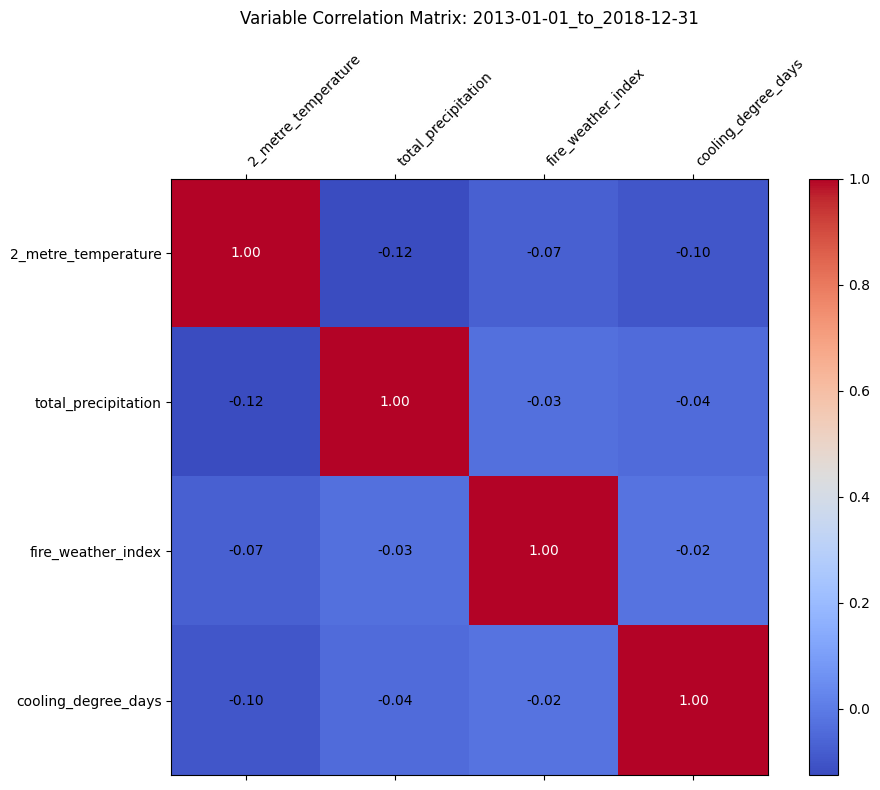


Correlation Matrix for 2013-01-01_to_2018-12-31:
                     2_metre_temperature  total_precipitation  \
2_metre_temperature             1.000000            -0.124849   
total_precipitation            -0.124849             1.000000   
fire_weather_index             -0.068673            -0.029681   
cooling_degree_days            -0.097374            -0.042086   

                     fire_weather_index  cooling_degree_days  
2_metre_temperature           -0.068673            -0.097374  
total_precipitation           -0.029681            -0.042086  
fire_weather_index             1.000000            -0.023149  
cooling_degree_days           -0.023149             1.000000  

Computing correlation matrix for 2019-01-01_to_2023-12-31...


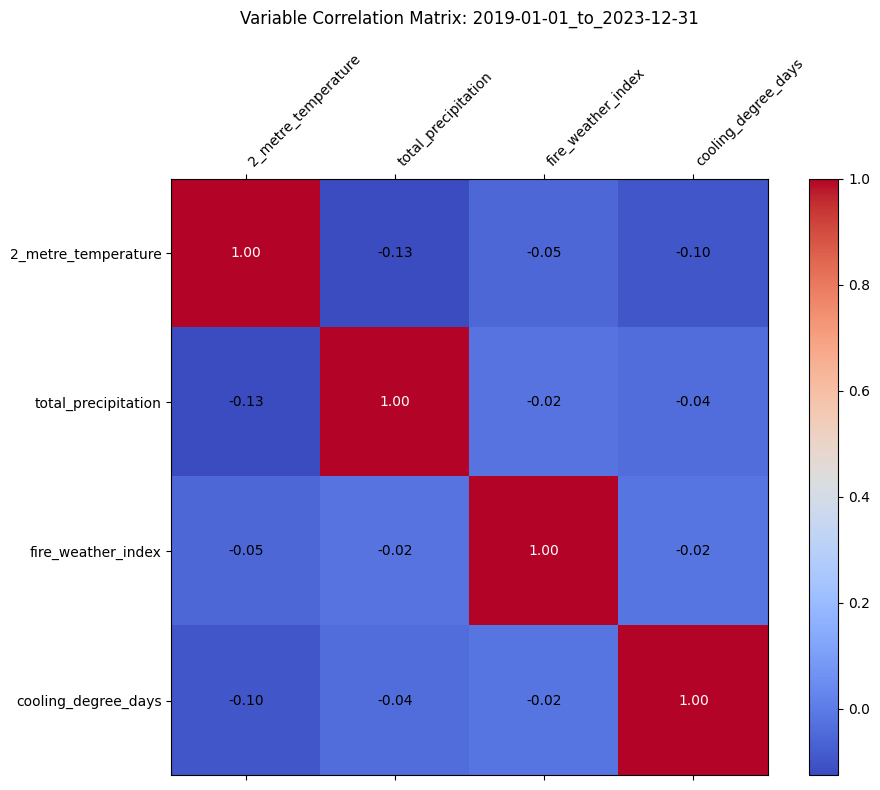


Correlation Matrix for 2019-01-01_to_2023-12-31:
                     2_metre_temperature  total_precipitation  \
2_metre_temperature             1.000000            -0.125529   
total_precipitation            -0.125529             1.000000   
fire_weather_index             -0.054184            -0.023213   
cooling_degree_days            -0.097844            -0.041918   

                     fire_weather_index  cooling_degree_days  
2_metre_temperature           -0.054184            -0.097844  
total_precipitation           -0.023213            -0.041918  
fire_weather_index             1.000000            -0.018093  
cooling_degree_days           -0.018093             1.000000  


In [33]:
# Correlation analysis for each segment DataFrame
for time_range, dataframe in segment_dataframes.items():
    print(f"\nComputing correlation matrix for {time_range}...")

    # Variables of interest
    variables_of_interest = [
        "2_metre_temperature",
        "total_precipitation",
        "fire_weather_index",
        "cooling_degree_days"
    ]

    # Select available variables in the DataFrame
    available_vars = [var for var in variables_of_interest if var in dataframe]

    if not available_vars:
        print(f"No variables of interest found in the DataFrame for {time_range}. Skipping.")
        continue

    # Preprocess DataFrame to handle missing values
    dataframe_subset = dataframe[available_vars]
    # Fill missing values with 0
    dataframe_subset = dataframe_subset.fillna(0)  

    if dataframe_subset.empty:
        print(f"No valid data available for correlation matrix in {time_range}. Skipping.")
        continue

    # Compute correlation matrix
    correlation_matrix = dataframe_subset.corr()

    # Visualize correlation matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(correlation_matrix, cmap="coolwarm")
    plt.colorbar(cax)

    # Add ticks and labels
    ax.set_xticks(np.arange(len(available_vars)))
    ax.set_yticks(np.arange(len(available_vars)))
    ax.set_xticklabels(available_vars, rotation=45, ha="left")
    ax.set_yticklabels(available_vars)

    # Annotate heatmap with values
    for i in range(len(available_vars)):
        for j in range(len(available_vars)):
            value = correlation_matrix.iloc[i, j]
            text_color = "white" if abs(value) > 0.5 else "black"
            ax.text(j, i, f"{value:.2f}", va="center", ha="center", color=text_color)

    plt.title(f"Variable Correlation Matrix: {time_range}", pad=20)
    plt.tight_layout()
    plt.show()

    # Print correlation matrix
    print(f"\nCorrelation Matrix for {time_range}:")
    print(correlation_matrix)

#### Trend Analysis


Analyzing trends for segment: 2013-01-01_to_2018-12-31...

Analyzing trend for: 2_metre_temperature in segment 2013-01-01_to_2018-12-31...

Analyzing trend for: total_precipitation in segment 2013-01-01_to_2018-12-31...

Analyzing trend for: fire_weather_index in segment 2013-01-01_to_2018-12-31...

Analyzing trend for: cooling_degree_days in segment 2013-01-01_to_2018-12-31...

Analyzing trends for segment: 2019-01-01_to_2023-12-31...

Analyzing trend for: 2_metre_temperature in segment 2019-01-01_to_2023-12-31...

Analyzing trend for: total_precipitation in segment 2019-01-01_to_2023-12-31...

Analyzing trend for: fire_weather_index in segment 2019-01-01_to_2023-12-31...

Analyzing trend for: cooling_degree_days in segment 2019-01-01_to_2023-12-31...


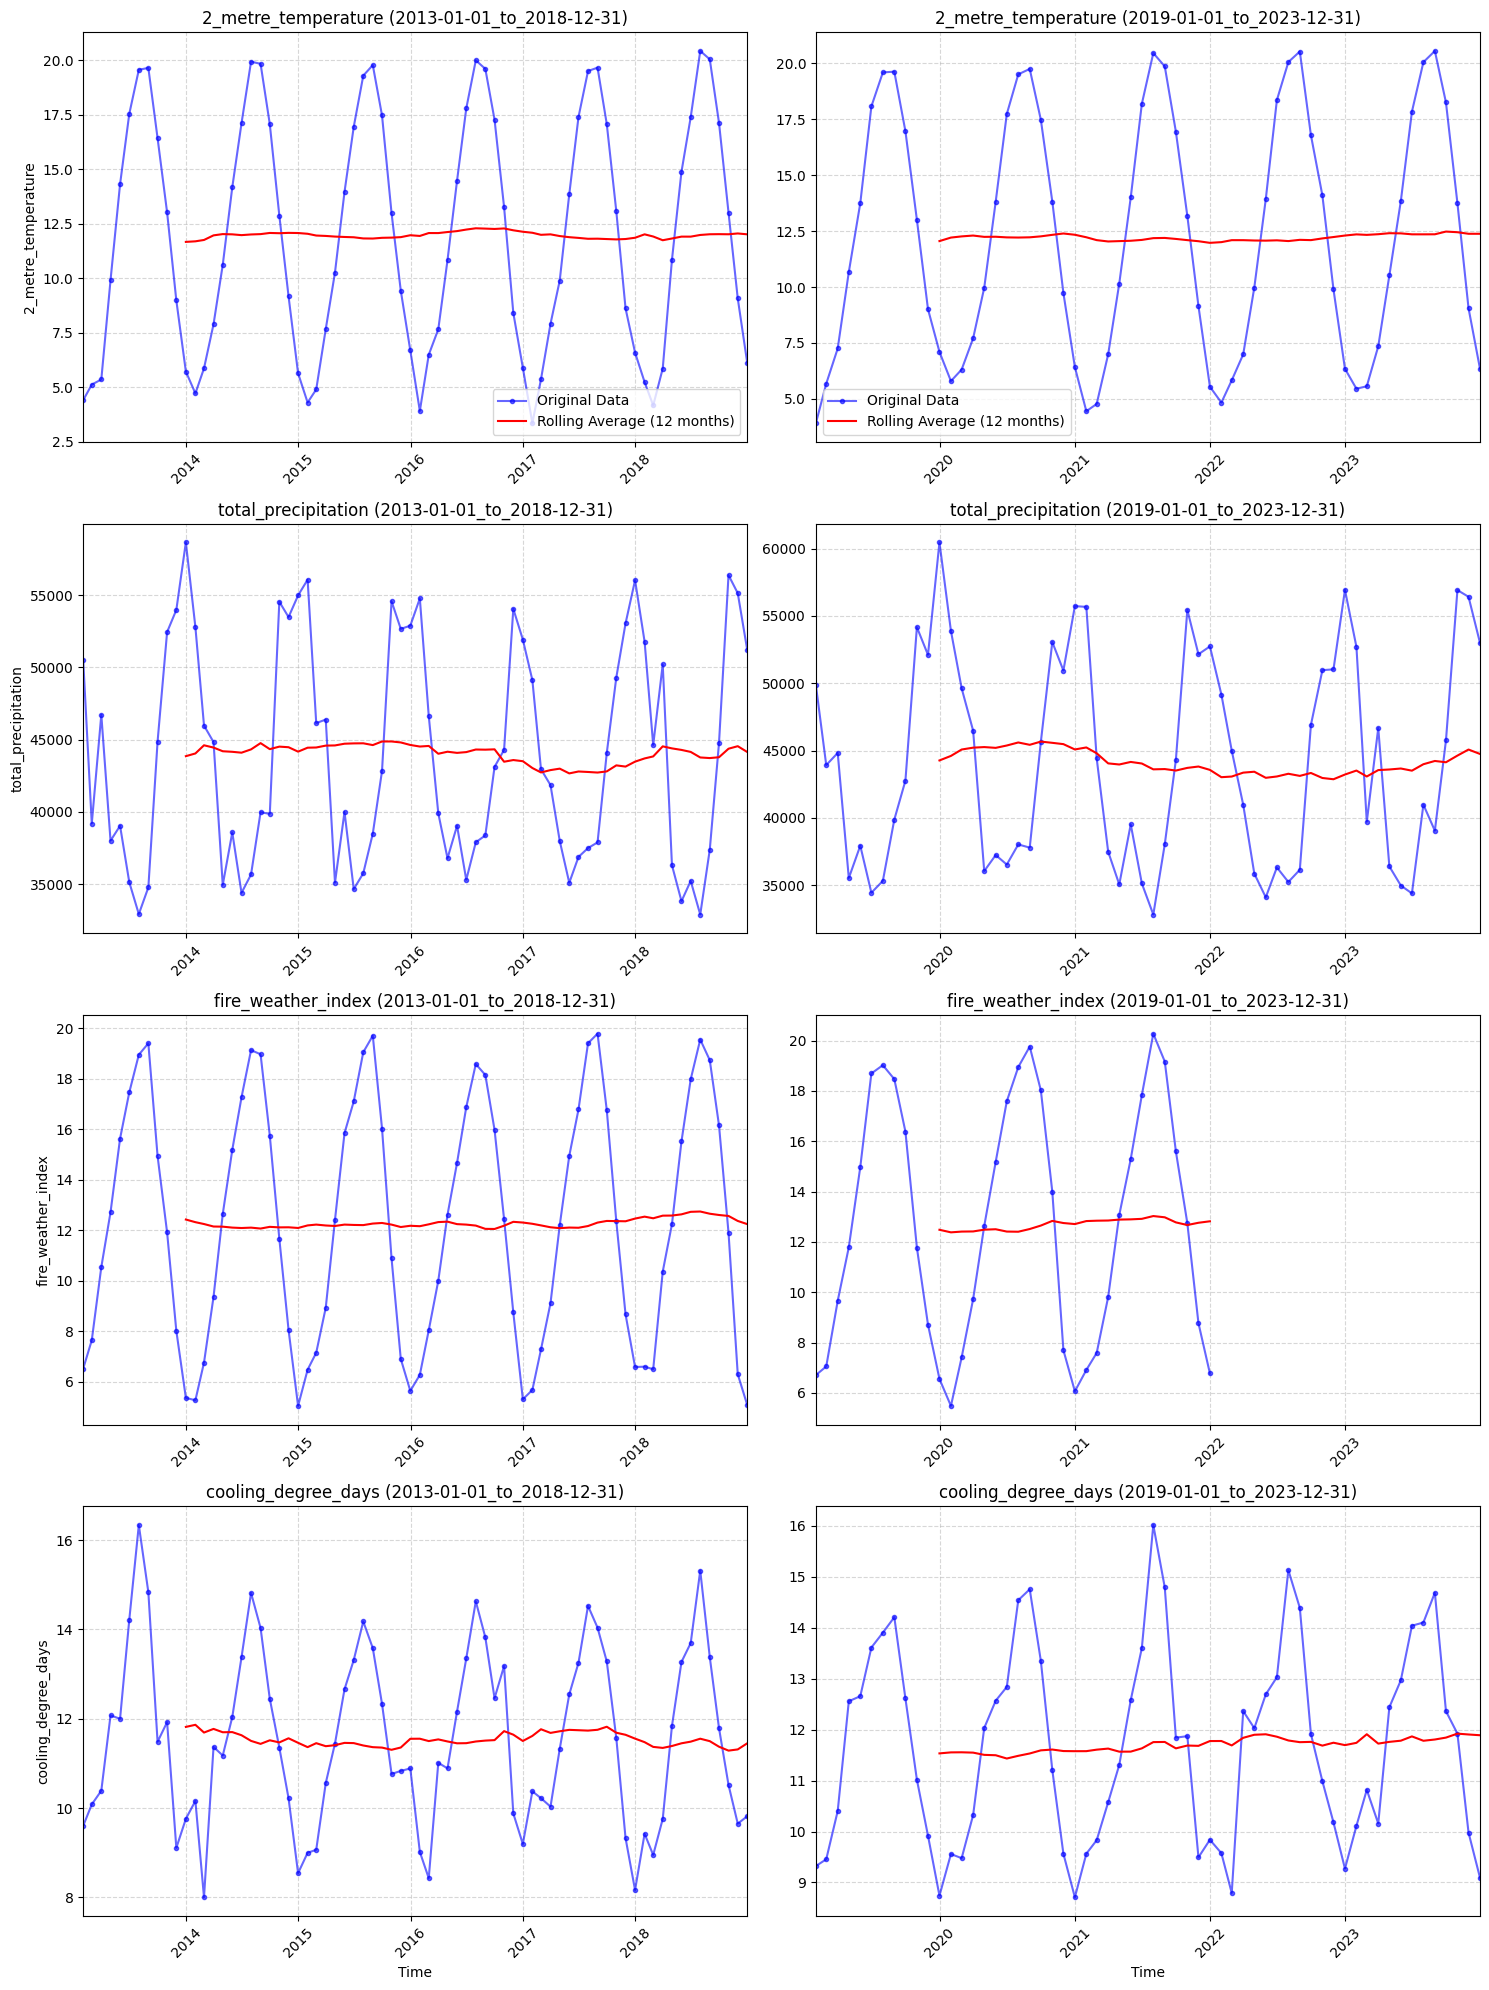

In [49]:
from matplotlib.dates import YearLocator, DateFormatter
import matplotlib.pyplot as plt
import pandas as pd

# Select key variables for analysis
variables_of_interest = [
    "2_metre_temperature",
    "total_precipitation",
    "fire_weather_index",
    "cooling_degree_days"
]

# Prepare subplots
n_variables = len(variables_of_interest)
n_segments = len(segment_dataframes)
fig, axes = plt.subplots(nrows=n_variables, ncols=n_segments, figsize=(15, 5 * n_variables), sharex=False)

if n_segments == 1:
    axes = np.expand_dims(axes, axis=1)  # Handle single-segment edge case

# Loop through each segment and variable to analyze trends
for col_idx, (time_range, dataframe) in enumerate(segment_dataframes.items()):
    print(f"\nAnalyzing trends for segment: {time_range}...")

    # Ensure 'time' is a proper datetime index
    if 'time' in dataframe.columns:
        dataframe['time'] = pd.to_datetime(dataframe['time'])
        dataframe.set_index('time', inplace=True)

    for row_idx, var in enumerate(variables_of_interest):
        if var in dataframe.columns:
            print(f"\nAnalyzing trend for: {var} in segment {time_range}...")

            # Get the time series for the variable
            time_series = dataframe[var]

            # Resample to ensure regular monthly intervals
            time_series = time_series.resample('M').mean()

            # Fill missing values
            # time_series = time_series.interpolate(method="linear")

            # Calculate a rolling average (12-month moving average)
            rolling_avg = time_series.rolling(window=12).mean()

            # Plot the original data and rolling average on subplot
            ax = axes[row_idx, col_idx]
            ax.plot(time_series, label="Original Data", color="blue", alpha=0.6, marker = '.')
            ax.plot(rolling_avg, label="Rolling Average (12 months)", color="red")

            # Add title, labels, and legend
            ax.set_title(f"{var} ({time_range})", fontsize=12)
            ax.set_xlabel("Time") if row_idx == n_variables - 1 else ax.set_xlabel("")
            ax.set_ylabel(var) if col_idx == 0 else ax.set_ylabel("")

            # Format x-axis to show available years only
            ax.set_xlim(time_series.index.min(), time_series.index.max())
            ax.xaxis.set_major_locator(YearLocator())
            ax.xaxis.set_major_formatter(DateFormatter('%Y'))
            ax.tick_params(axis='x', rotation=45)  # Rotate year labels

            # Add grid and legend
            ax.grid(True, linestyle="--", alpha=0.5)
            if row_idx == 0:  # Show legend only on top row
                ax.legend()
        else:
            print(f"Variable '{var}' not found in segment {time_range}.")

# Adjust layout
plt.tight_layout()
plt.show()


 ##### Temperature vs. Fire weather index over time

In [57]:
# # Plot temperature vs fire weather index for the first year in each segment
# for time_range, dataframe in segment_dataframes.items():
#     print(f"\nPlotting relationship between temperature and fire weather index for the first year of segment: {time_range}...")

#     # Ensure 'time' is a proper datetime index
#     if 'time' in dataframe.columns:
#         dataframe['time'] = pd.to_datetime(dataframe['time'])
#         dataframe.set_index('time', inplace=True)

#     if "2_metre_temperature" in dataframe.columns and "fire_weather_index" in dataframe.columns:
#         # Filter data for the first year
#         first_year = dataframe.index.min().year
#         first_year_data = dataframe[dataframe.index.year == first_year]

#         temp_series = first_year_data["2_metre_temperature"]
#         fwi_series = first_year_data["fire_weather_index"]

#         # Plot the data
#         plt.figure(figsize=(12, 6))
#         plt.plot(temp_series, label="2 Metre Temperature", color="blue")
#         plt.plot(fwi_series, label="Fire Weather Index", color="orange")

#         # Add title and labels
#         plt.title(f"Temperature vs Fire Weather Index (First Year of {time_range})", fontsize=14)
#         plt.xlabel("Time")
#         plt.ylabel("Value")

#         # Format x-axis to show months within the first year
#         plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
#         plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#         plt.xticks(rotation=45)

#         # Add legend and grid
#         plt.legend()
#         plt.grid(True, linestyle="--", alpha=0.5)

#         # Show the plot
#         plt.show()
#     else:
#         print(f"Temperature or Fire Weather Index not found in segment {time_range}.")
